# Importing packages

In [403]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [404]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [405]:
import pickle

In [406]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [407]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "DescOnly_red0_old0410_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250508_v1" #date and versioning

saving_dirrectory = "012 Processed Data\\017_noNotes_t-60"
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_descOnly_red0_old0410_", 
                                     folderName_common= "250508_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data\\017_noNotes_t-60"
figFolder = makingFolder 


In [408]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [409]:
#parameters of SVM 
red_factor = 0

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]

# importing our data

In [410]:
dataFileName = "DF_SVM_noNotes_t-60_DescOnly__20250506_v1.xlsx"

This data set contains descriptive statistics and demographic information for patients with known cardiac amyloidosis status. No physician note data was included in the dataset. Time was restricted to 60 days prior to oncologic diagnosis through all positive time points.

In [411]:
# "C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_noNotes_t-60__20250506_v1\DF_SVM_noNotes_t-60_DescOnly__20250506_v1.xlsx"

## list of prior featurse that were selected by this model

In [412]:
priorFeaturesName = 'SVM_model_comparison_noNotes_t-60.xlsx'

In [413]:
#sheets with prior selected features for this same starting feature list "feature selection"
#header rows 2, 'model' , 'feature reduction', in column 0
priorFeatures_df = pd.read_excel(priorFeaturesName, sheet_name='feature selection', header = [0,1]) #data set we are using
priorModel = 'DescOnly no notes' #original data conditions
priorFeatureRed = 0.3 #feature reduction rate

priorFeaturesList = list(priorFeatures_df[priorModel, priorFeatureRed].dropna())

In [414]:
#sheets with old features "old features"
#header rows 3, 'model' , 'feature reduction', 'date' in column 0
oldFeatures_df = pd.read_excel(priorFeaturesName, sheet_name = "old features", header = [0,1,2]) #the dataset we are using
#what model are you looking for
oldModel = 'DescOnly' #original data
oldFeatureRed = 0.25 #feature reduction rate
oldDate = 20250410 #date of model

oldFeaturesList = list(oldFeatures_df[oldModel, oldFeatureRed, oldDate].dropna())

In [415]:
x_columns_toKeep = oldFeaturesList #features to use in the initial feature list

## filtering the features

In [416]:
# Import dataset
dataTable = pd.read_excel(dataFileName, sheet_name = "knownPts", header = 0) #the dataset we are using

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
x_columns_Compare = [feature for feature in x_columns_toKeep if feature in X.columns]
X = X[x_columns_Compare]

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

# Setting up classifier

## Scaling data and defining test set

In [417]:
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

max(X_all[:,0])

3.657779052600433

## define cross validation

In [418]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [419]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.96, 'auc': 0.9777777777777779, 'score': 0.968888888888889, 'C': 16}

In [420]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


{'f1': 0.888888888888889,
 'auc': 0.9500000000000001,
 'true neg': 4,
 'false pos': 1,
 'false neg': 0,
 'true pos': 4,
 'precision or PPV': 0.8,
 'recall or TPR': 1.0,
 'specificity or TNR': 0.8}

## testing other models

In [421]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [422]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

ROC:  0.9
F1:  0.8888888888888888


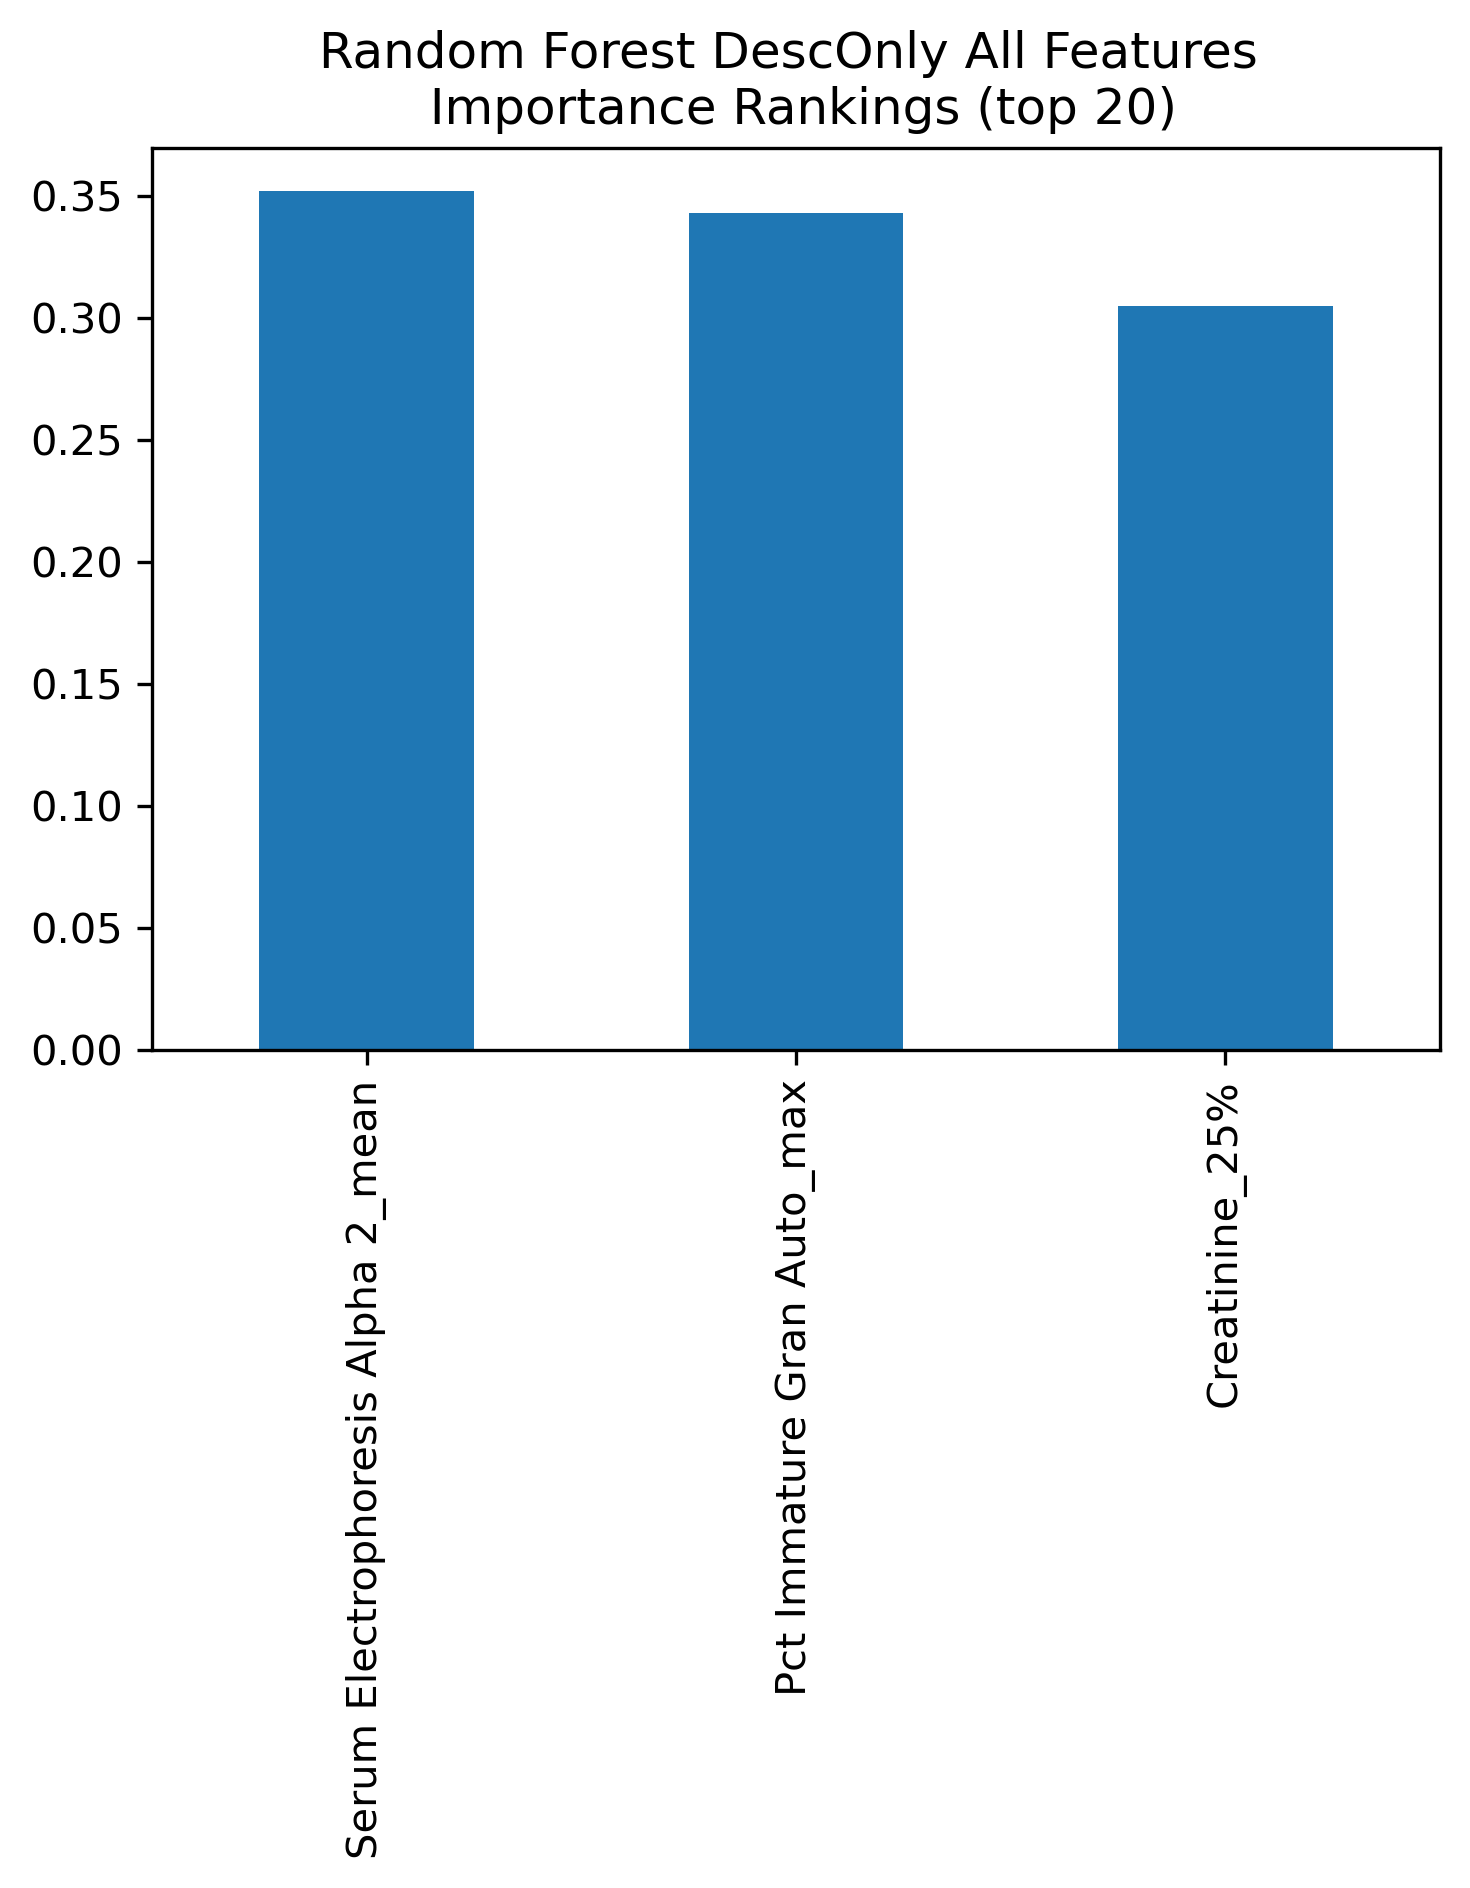

In [423]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest DescOnly All Features \n Importance Rankings (top 20)")

# Show the plot
plt.show()

In [424]:
what_train = pd.DataFrame(X_train, columns = X.columns) 
what_test = pd.DataFrame(X_test, columns = X.columns) 

In [425]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(what_train[list(top_20_importances.index[:7])], y_train)
y_pred = rnd_clf.predict(what_test[list(top_20_importances.index[:7])])
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= what_train[list(top_20_importances.index[:7])].columns)

ROC:  0.9
F1:  0.8888888888888888


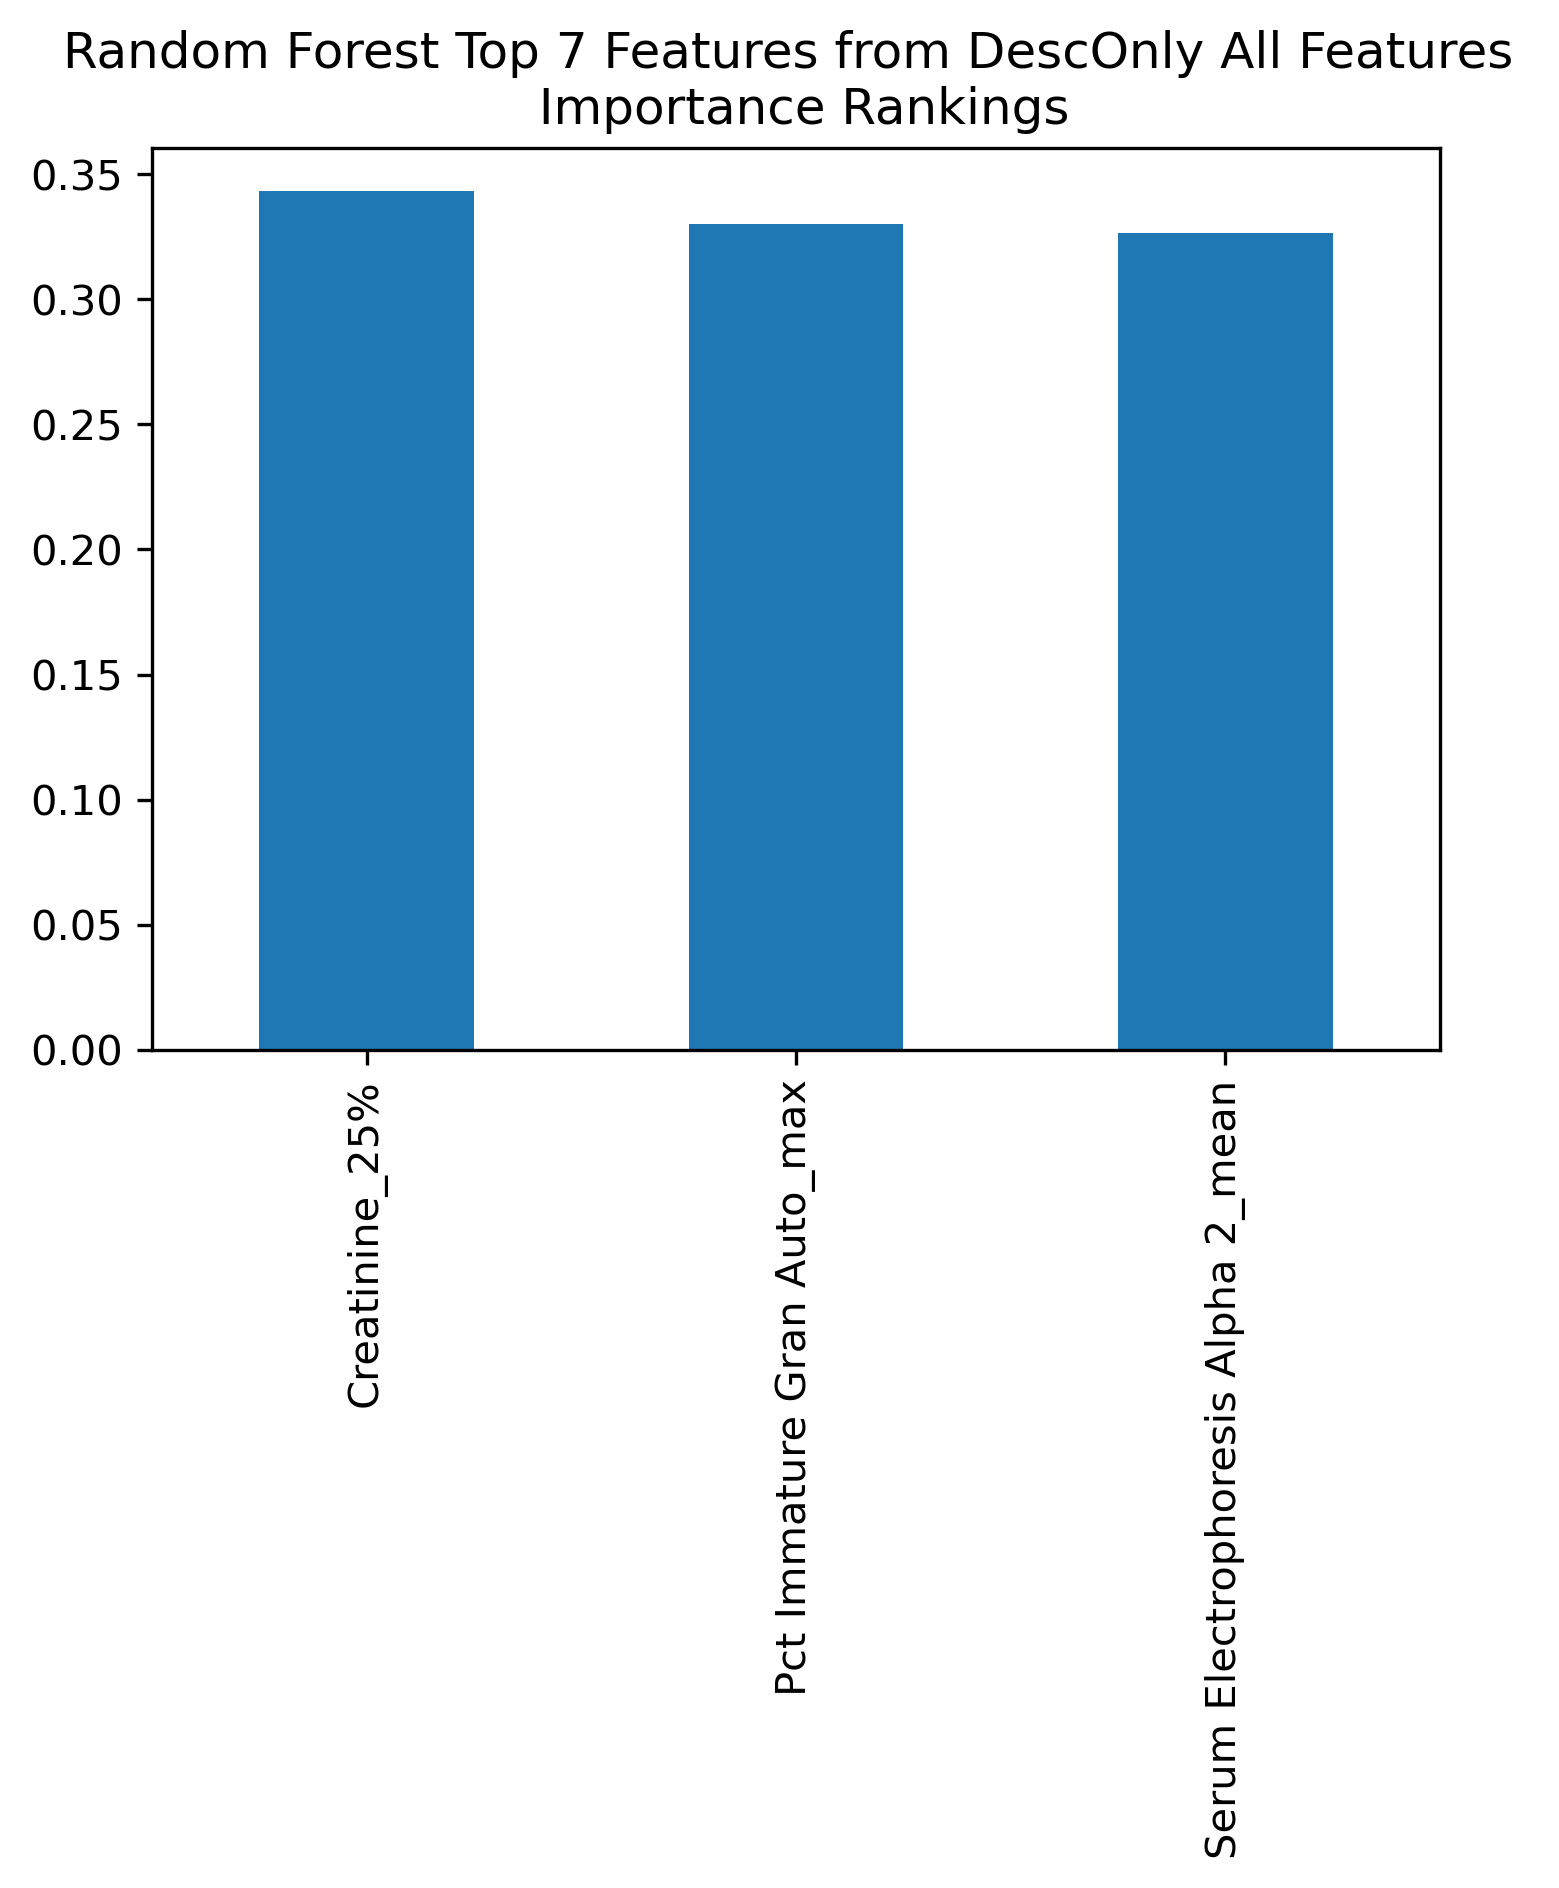

In [426]:
# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest Top 7 Features from DescOnly All Features \n Importance Rankings")

# Show the plot
plt.show()

In [427]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

ROC:  0.675
F1:  0.6666666666666666


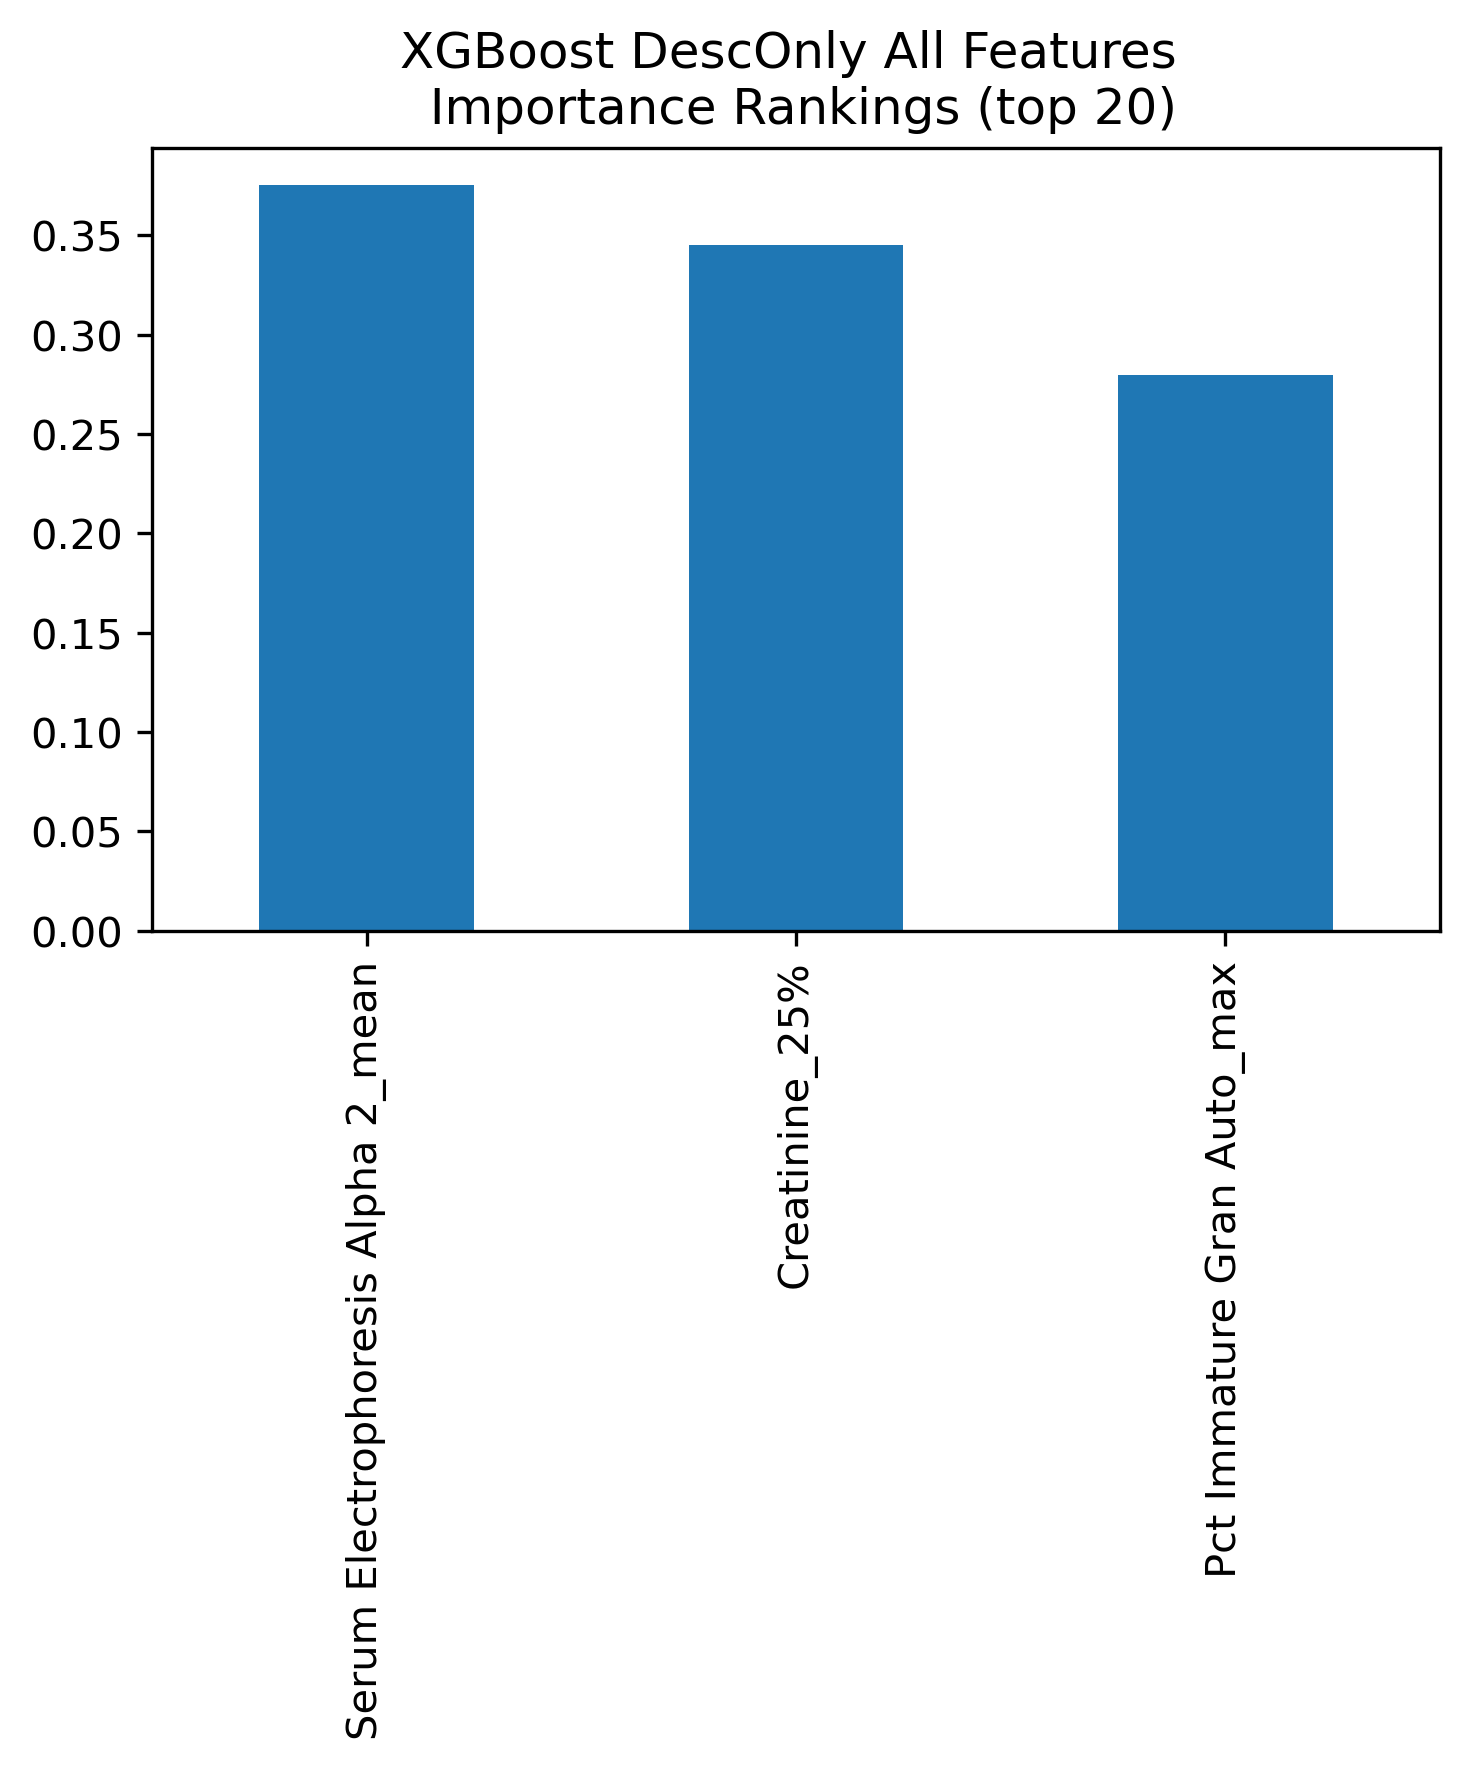

In [428]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost DescOnly All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [429]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



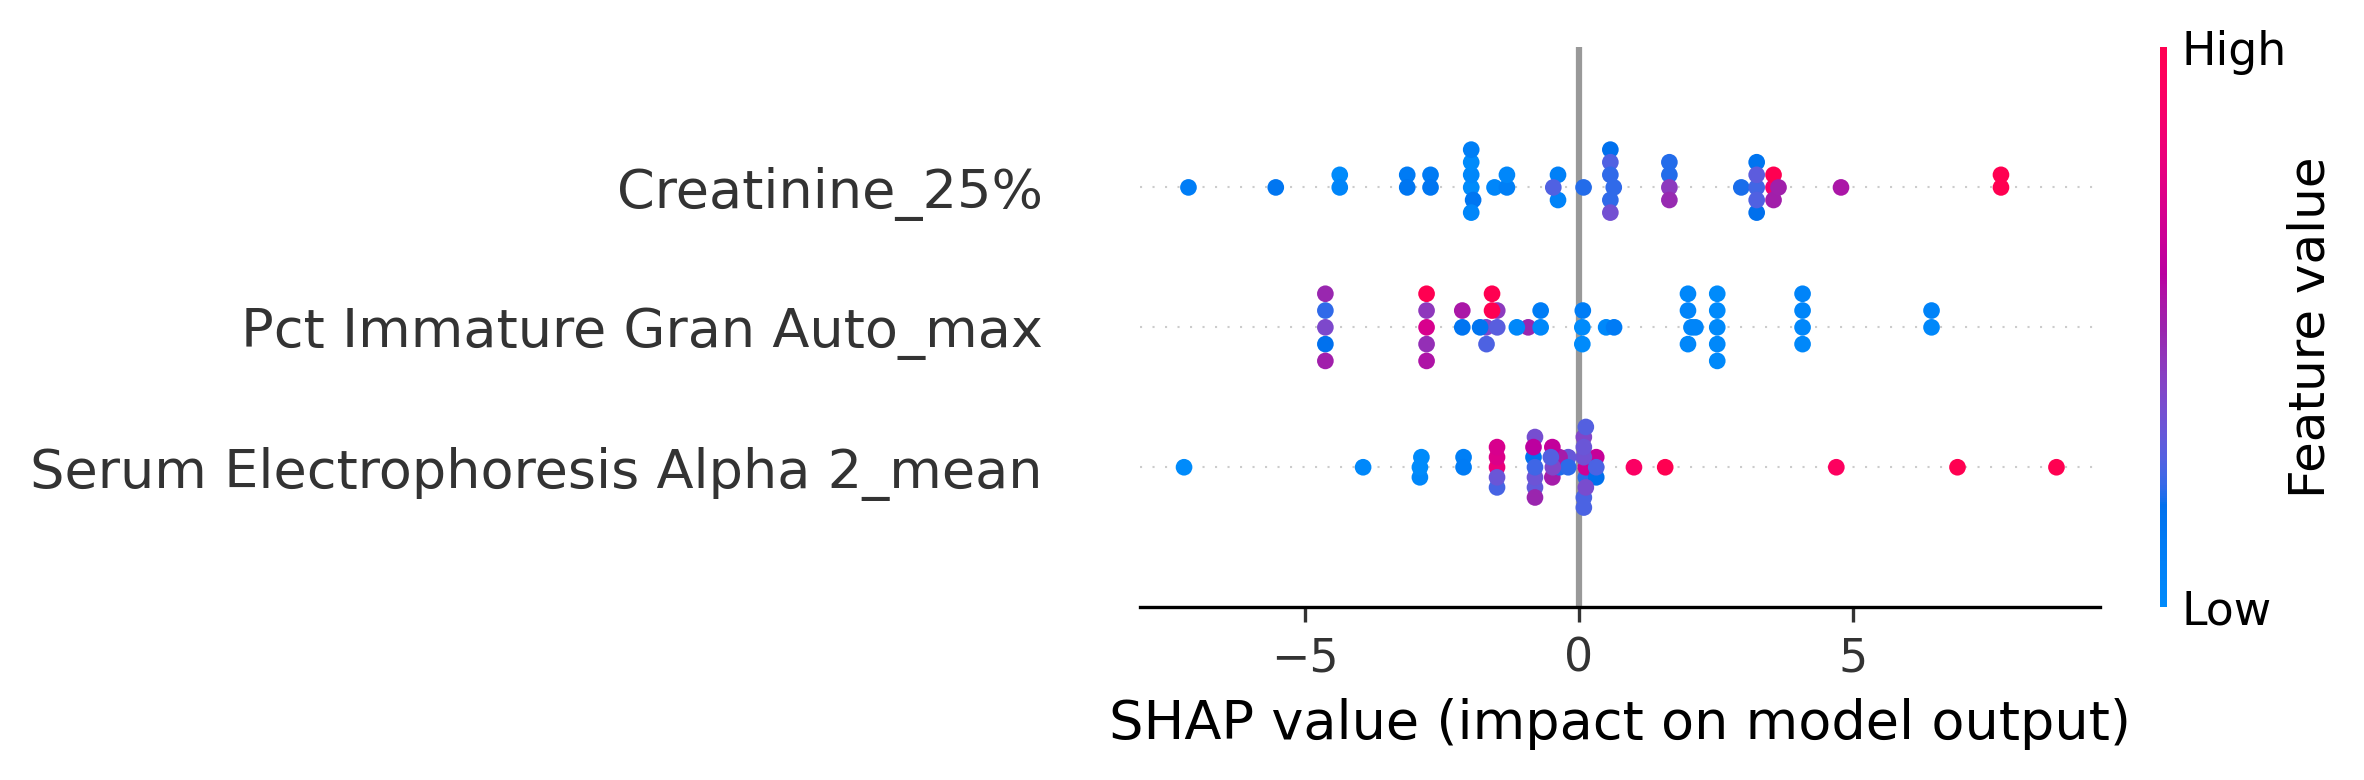

In [430]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [431]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.907
Number of Features: 1, Score: 0.789
Rank weight: 0.15
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.907
Number of Features: 1, Score: 0.789
Rank weight: 0.20
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.907
Number of Features: 1, Score: 0.789
Rank weight: 0.25
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.907
Number of Features: 1, Score: 0.789
Rank weight: 0.30
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.907
Number of Features: 1, Score: 0.789
Rank weight: 0.40
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.748
Number of Features: 1, Score: 0.697
Rank weight: 0.50
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.748
Number of Features: 1, Score: 0.697
Rank weight: 0.60
Number of Features: 3, Score: 0.969
Number of Features: 2, Score: 0.748
Number of Features: 1, Score

# Performance plots

## F1 and AUC plots

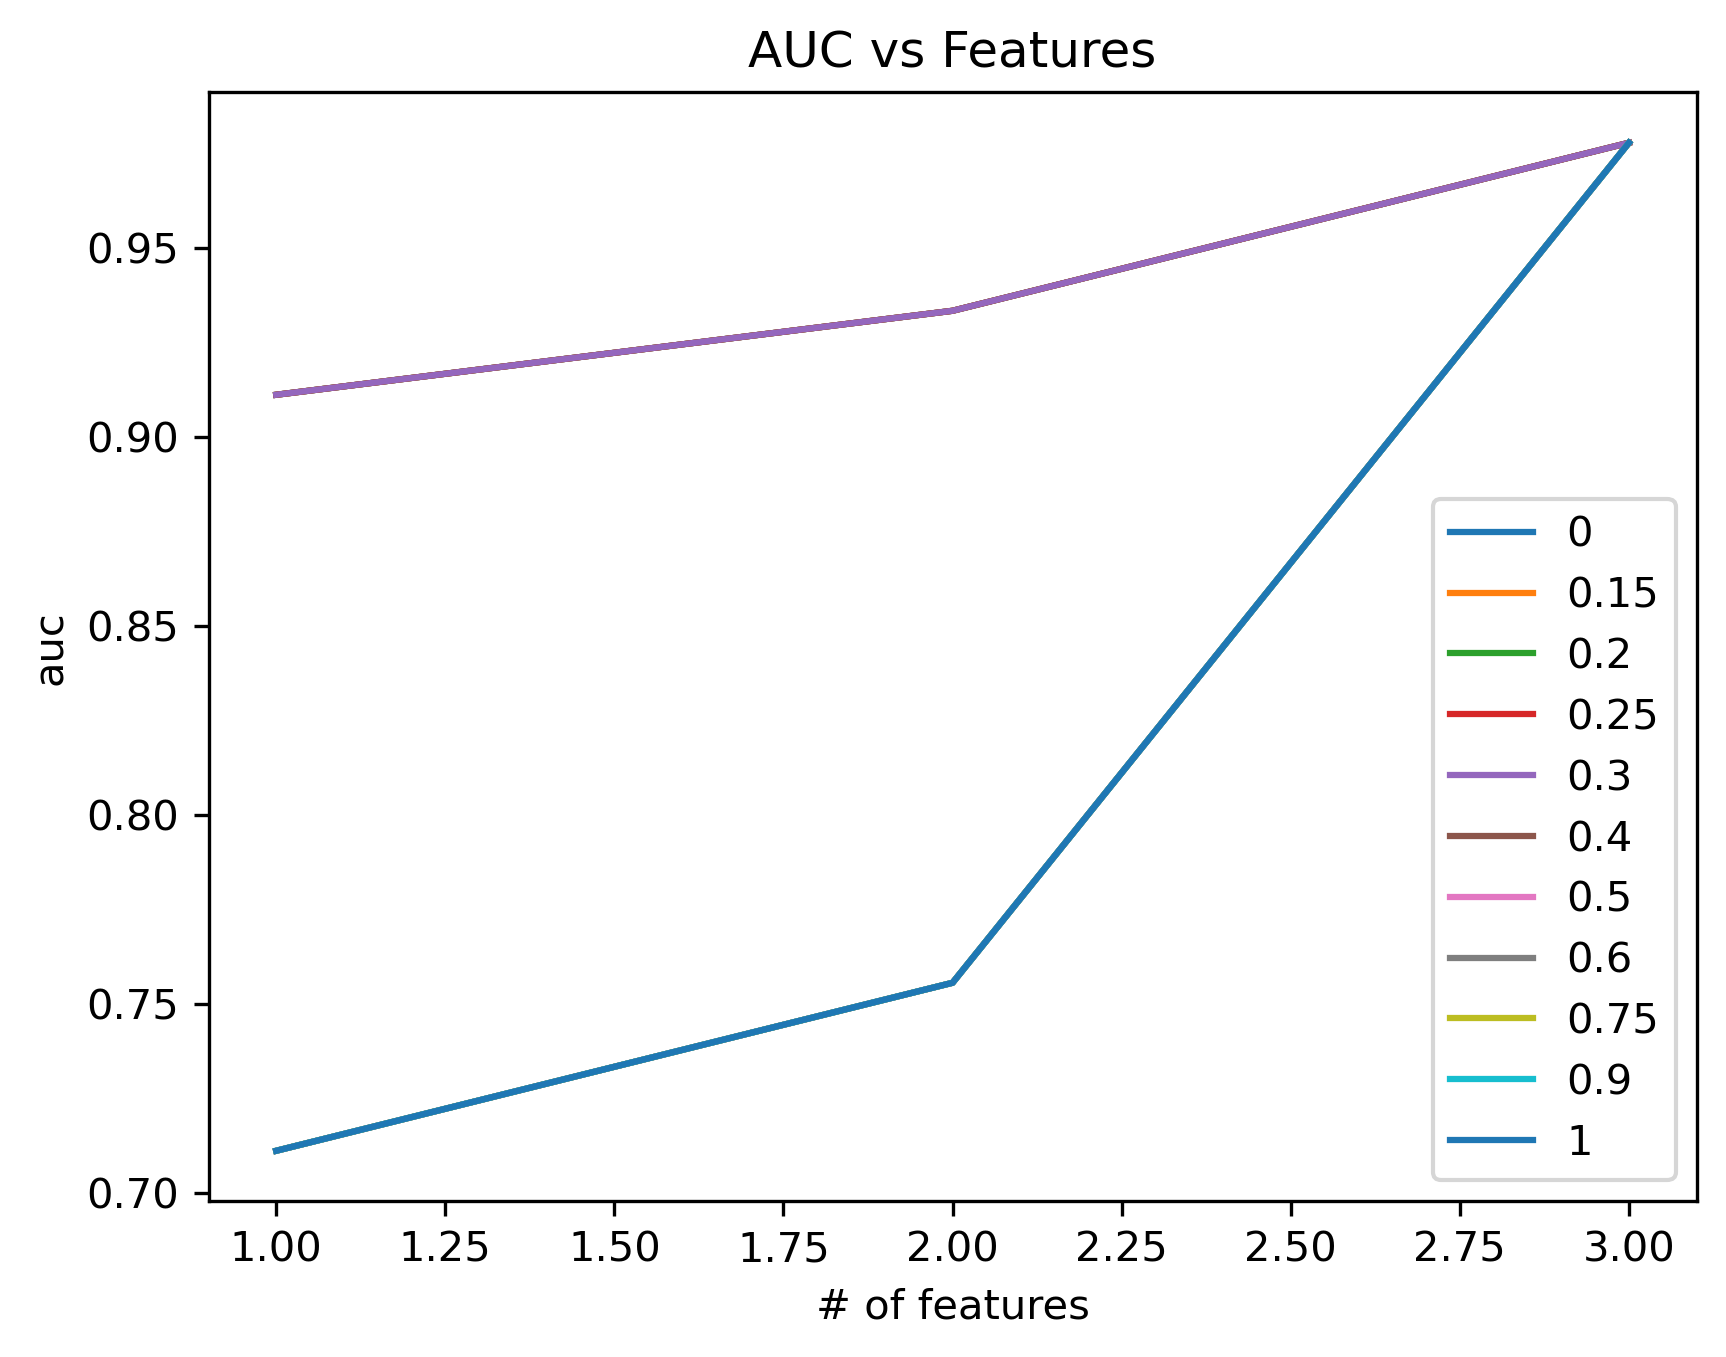

In [432]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

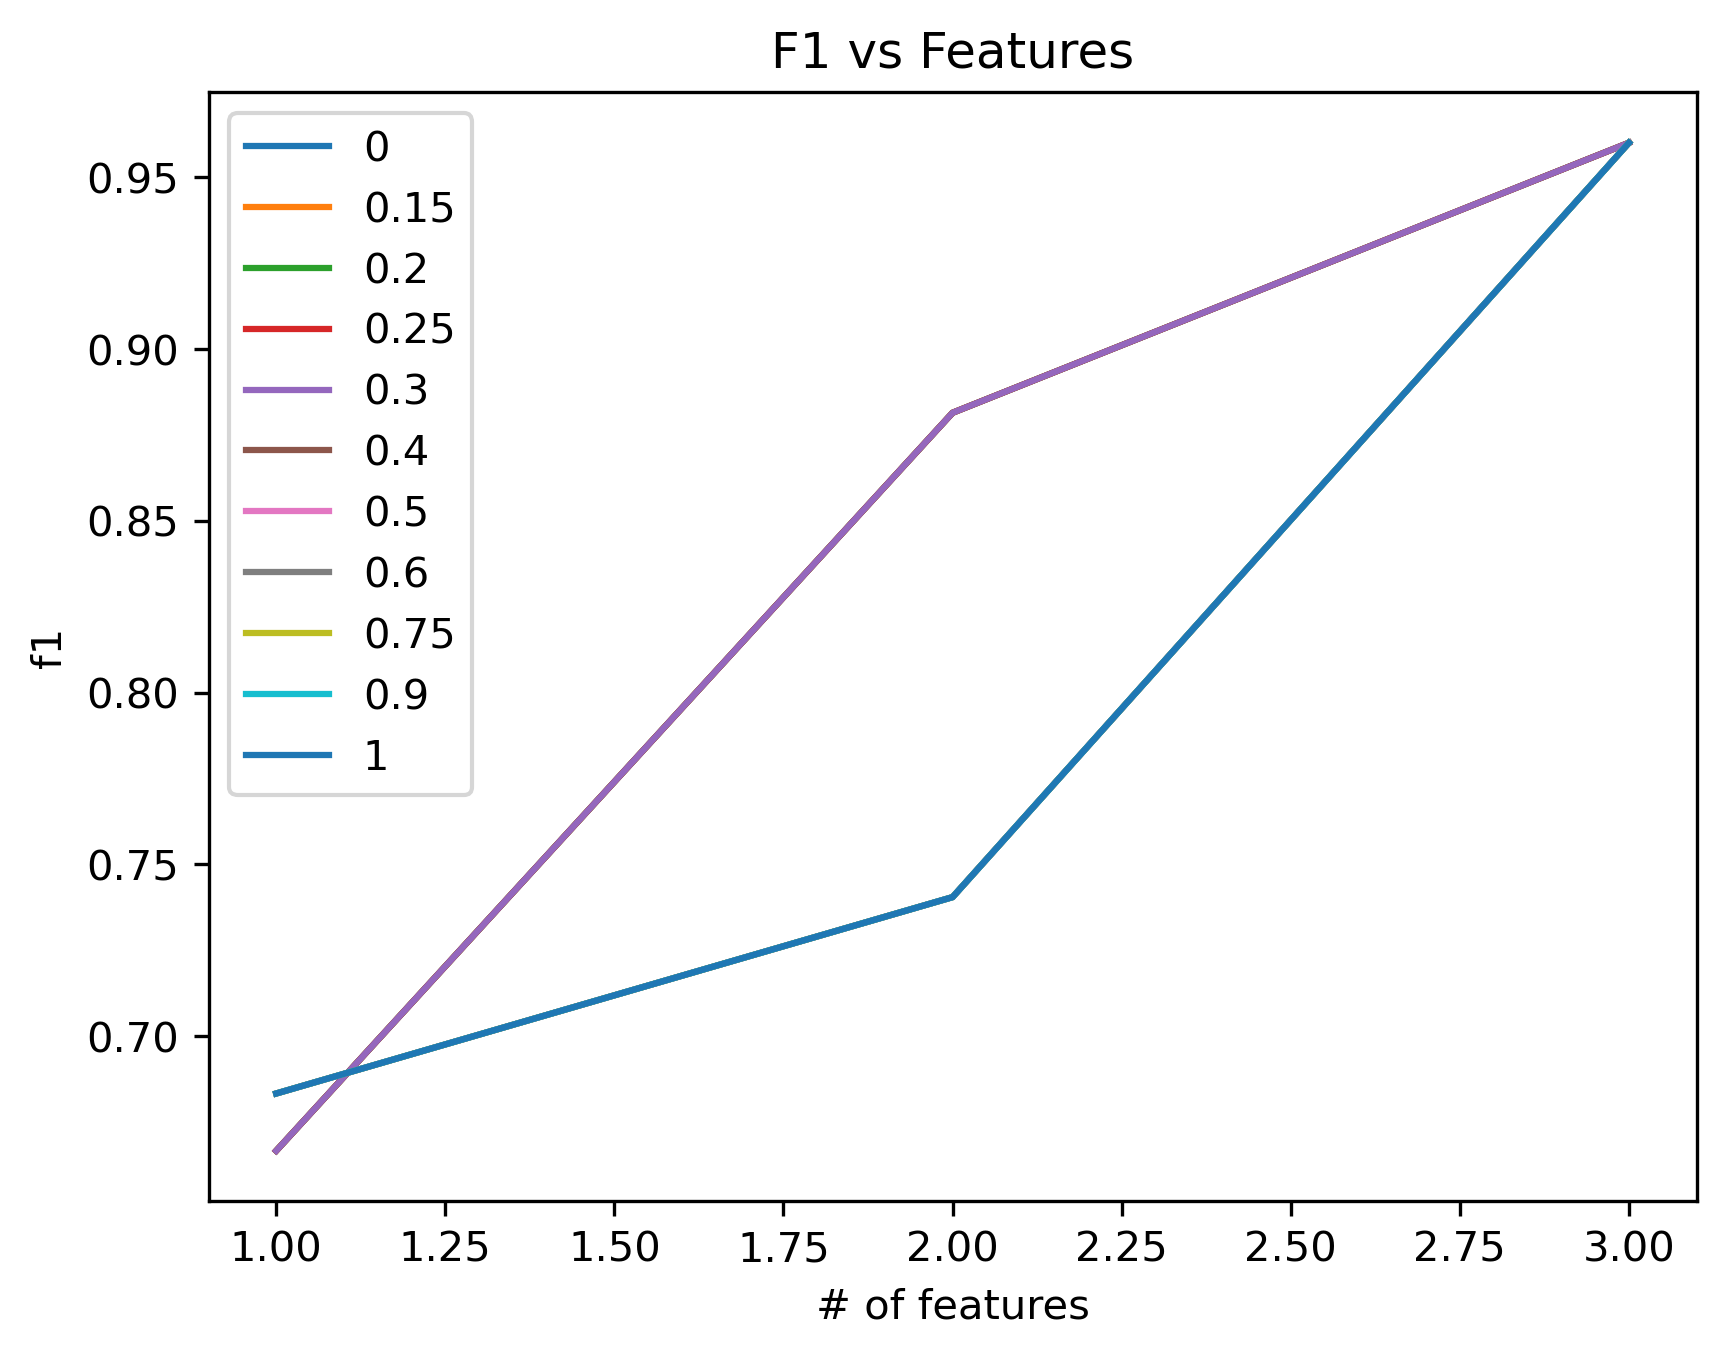

In [433]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

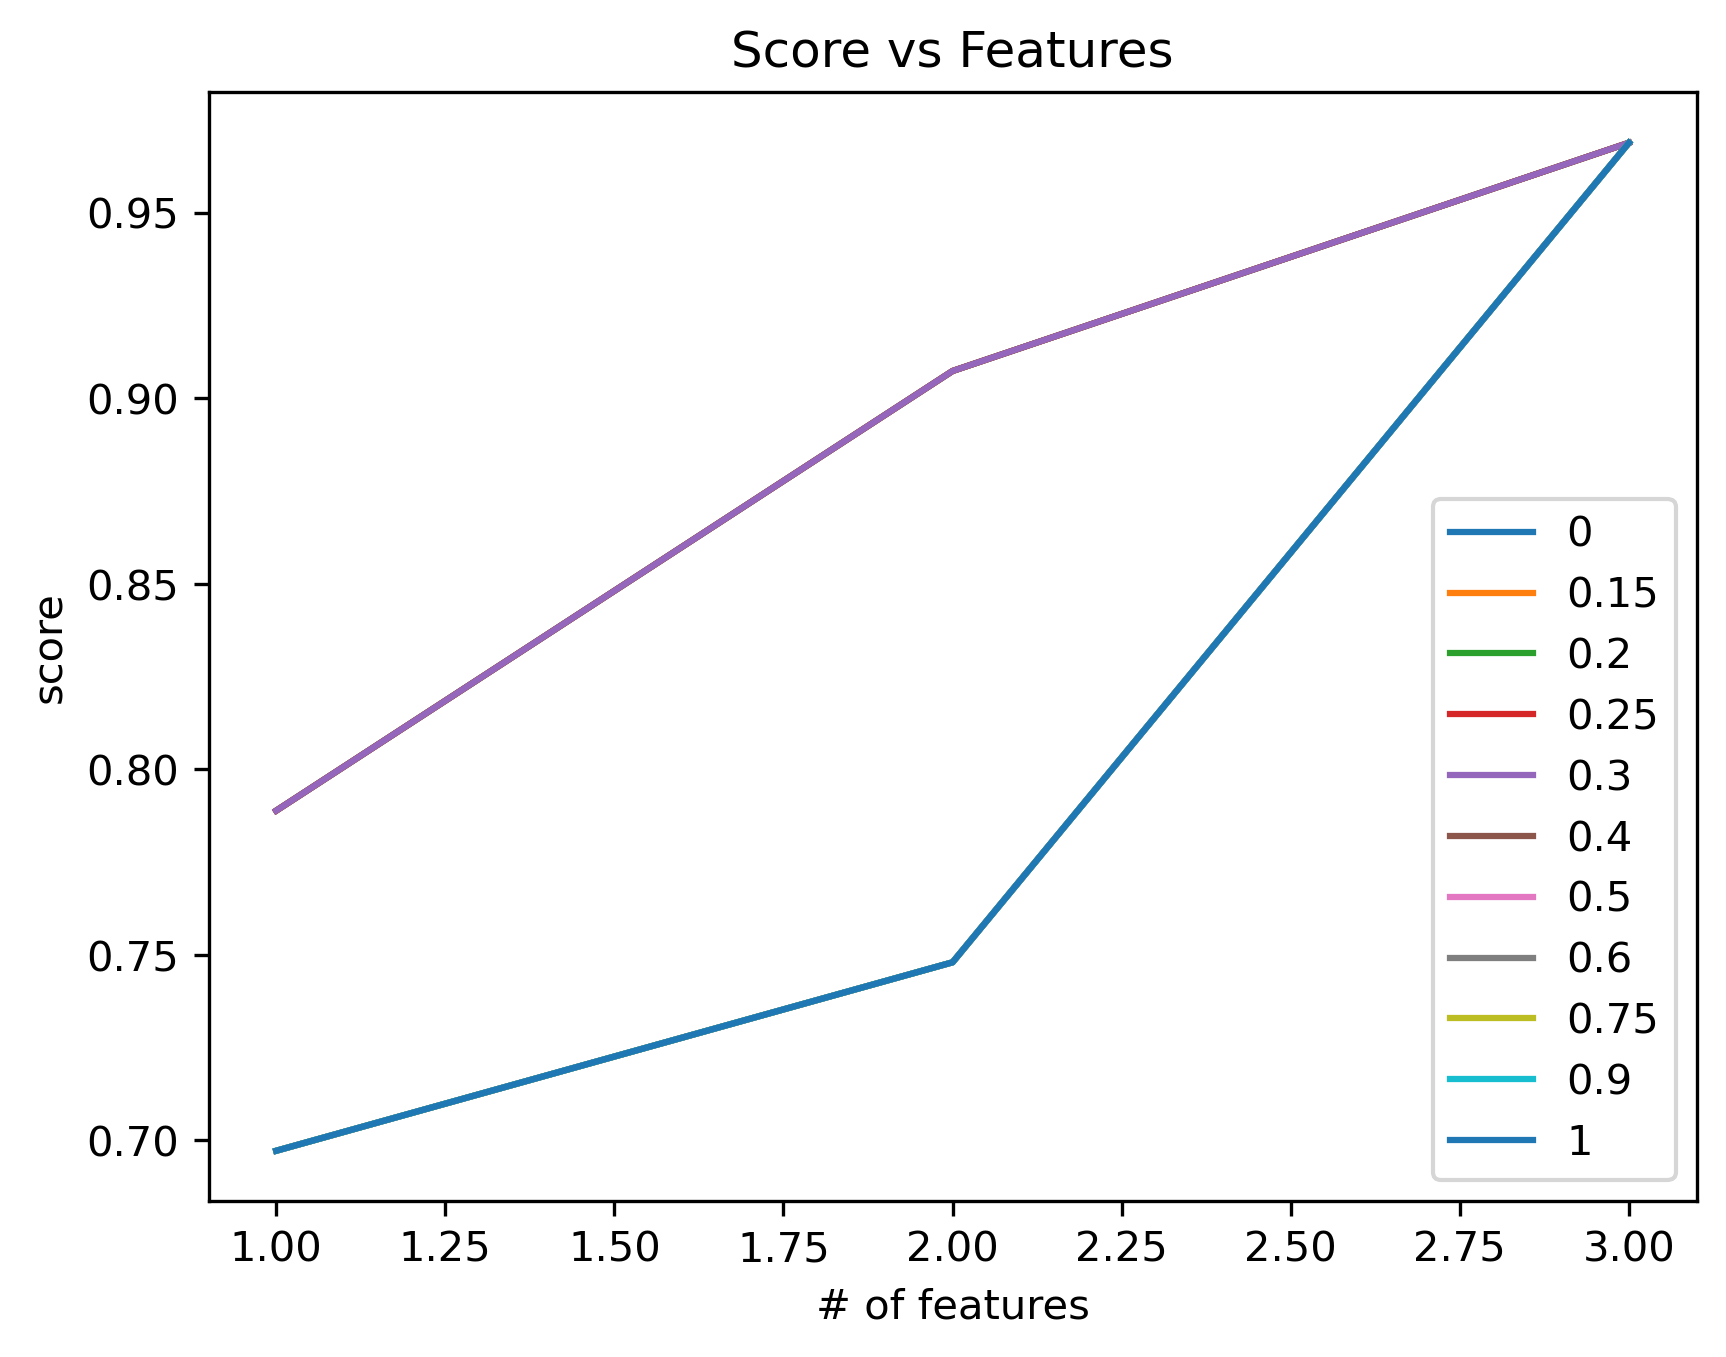

In [434]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [435]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.5954232804232804,
 0.5954232804232804,
 0.5954232804232804,
 0.5954232804232804,
 0.5954232804232804,
 0.5270238095238096,
 0.5270238095238096,
 0.5270238095238096,
 0.5270238095238096,
 0.5270238095238096,
 0.5270238095238096]

In [436]:
svm_set_ranks[selected_run].performance_

{'f1': 0.96,
 'auc': 0.9777777777777779,
 'score': 0.968888888888889,
 'C': 16,
 'num_features': 3,
 'mean_nSV': 13.4}

In [437]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [438]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [439]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [440]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.888889  0.95       4.0        1.0        0.0       4.0   
0.15  0.888889  0.95       4.0        1.0        0.0       4.0   
0.2   0.888889  0.95       4.0        1.0        0.0       4.0   
0.25  0.888889  0.95       4.0        1.0        0.0       4.0   
0.3   0.888889  0.95       4.0        1.0        0.0       4.0   
0.4   0.888889  0.95       4.0        1.0        0.0       4.0   
0.5   0.888889  0.95       4.0        1.0        0.0       4.0   
0.6   0.888889  0.95       4.0        1.0        0.0       4.0   
0.75  0.888889  0.95       4.0        1.0        0.0       4.0   
0.9   0.888889  0.95       4.0        1.0        0.0       4.0   
1     0.888889  0.95       4.0        1.0        0.0       4.0   

      precision or PPV  recall or TPR  specificity or TNR  
0                  0.8            1.0                 0.8  
0.15               0.8            1.0                 0.8  
0.2                0.8            1.0                 0.8  
0.25               0.8            1.0                 0.8  
0.3                0.8            1.0                 0.8  
0.4                0.8            1.0                 0.8  
0.5                0.8            1.0                 0.8  
0.6                0.8            1.0                 0.8  
0.75               0.8            1.0                 0.8  
0.9                0.8            1.0                 0.8  
1                  0.8            1.0                 0.8

In [441]:
df_performance

f1       auc     score     C  num_features  mean_nSV
0     0.96  0.977778  0.968889  16.0           3.0      13.4
0.15  0.96  0.977778  0.968889  16.0           3.0      13.4
0.2   0.96  0.977778  0.968889  16.0           3.0      13.4
0.25  0.96  0.977778  0.968889  16.0           3.0      13.4
0.3   0.96  0.977778  0.968889  16.0           3.0      13.4
0.4   0.96  0.977778  0.968889  16.0           3.0      13.4
0.5   0.96  0.977778  0.968889  16.0           3.0      13.4
0.6   0.96  0.977778  0.968889  16.0           3.0      13.4
0.75  0.96  0.977778  0.968889  16.0           3.0      13.4
0.9   0.96  0.977778  0.968889  16.0           3.0      13.4
1     0.96  0.977778  0.968889  16.0           3.0      13.4

In [442]:
df_features

0                                0.15  \
0                      Creatinine_25%                      Creatinine_25%   
1          Pct Immature Gran Auto_max          Pct Immature Gran Auto_max   
2  Serum Electrophoresis Alpha 2_mean  Serum Electrophoresis Alpha 2_mean   

                                  0.2                                0.25  \
0                      Creatinine_25%                      Creatinine_25%   
1          Pct Immature Gran Auto_max          Pct Immature Gran Auto_max   
2  Serum Electrophoresis Alpha 2_mean  Serum Electrophoresis Alpha 2_mean   

                                  0.3                                 0.4  \
0                      Creatinine_25%                      Creatinine_25%   
1          Pct Immature Gran Auto_max          Pct Immature Gran Auto_max   
2  Serum Electrophoresis Alpha 2_mean  Serum Electrophoresis Alpha 2_mean   

                                  0.5                                 0.6  \
0                      Creatinine_25%                      Creatinine_25%   
1          Pct Immature Gran Auto_max          Pct Immature Gran Auto_max   
2  Serum Electrophoresis Alpha 2_mean  Serum Electrophoresis Alpha 2_mean   

                                 0.75                                 0.9  \
0                      Creatinine_25%                      Creatinine_25%   
1          Pct Immature Gran Auto_max          Pct Immature Gran Auto_max   
2  Serum Electrophoresis Alpha 2_mean  Serum Electrophoresis Alpha 2_mean   

                                    1  
0                      Creatinine_25%  
1          Pct Immature Gran Auto_max  
2  Serum Electrophoresis Alpha 2_mean

## best model performance

In [443]:
print("rank weights: ", str(rank_weights[selected_run]))
print(df_performance.iloc[selected_run])
print(df_blindprediction.iloc[selected_run])

rank weights:  0
f1               0.960000
auc              0.977778
score            0.968889
C               16.000000
num_features     3.000000
mean_nSV        13.400000
Name: 0, dtype: float64
f1                    0.888889
auc                   0.950000
true neg              4.000000
false pos             1.000000
false neg             0.000000
true pos              4.000000
precision or PPV      0.800000
recall or TPR         1.000000
specificity or TNR    0.800000
Name: 0, dtype: float64


In [444]:
df_features[str(rank_weights[selected_run])].dropna()

0                        Creatinine_25%
1            Pct Immature Gran Auto_max
2    Serum Electrophoresis Alpha 2_mean
Name: 0, dtype: object

## pair plots

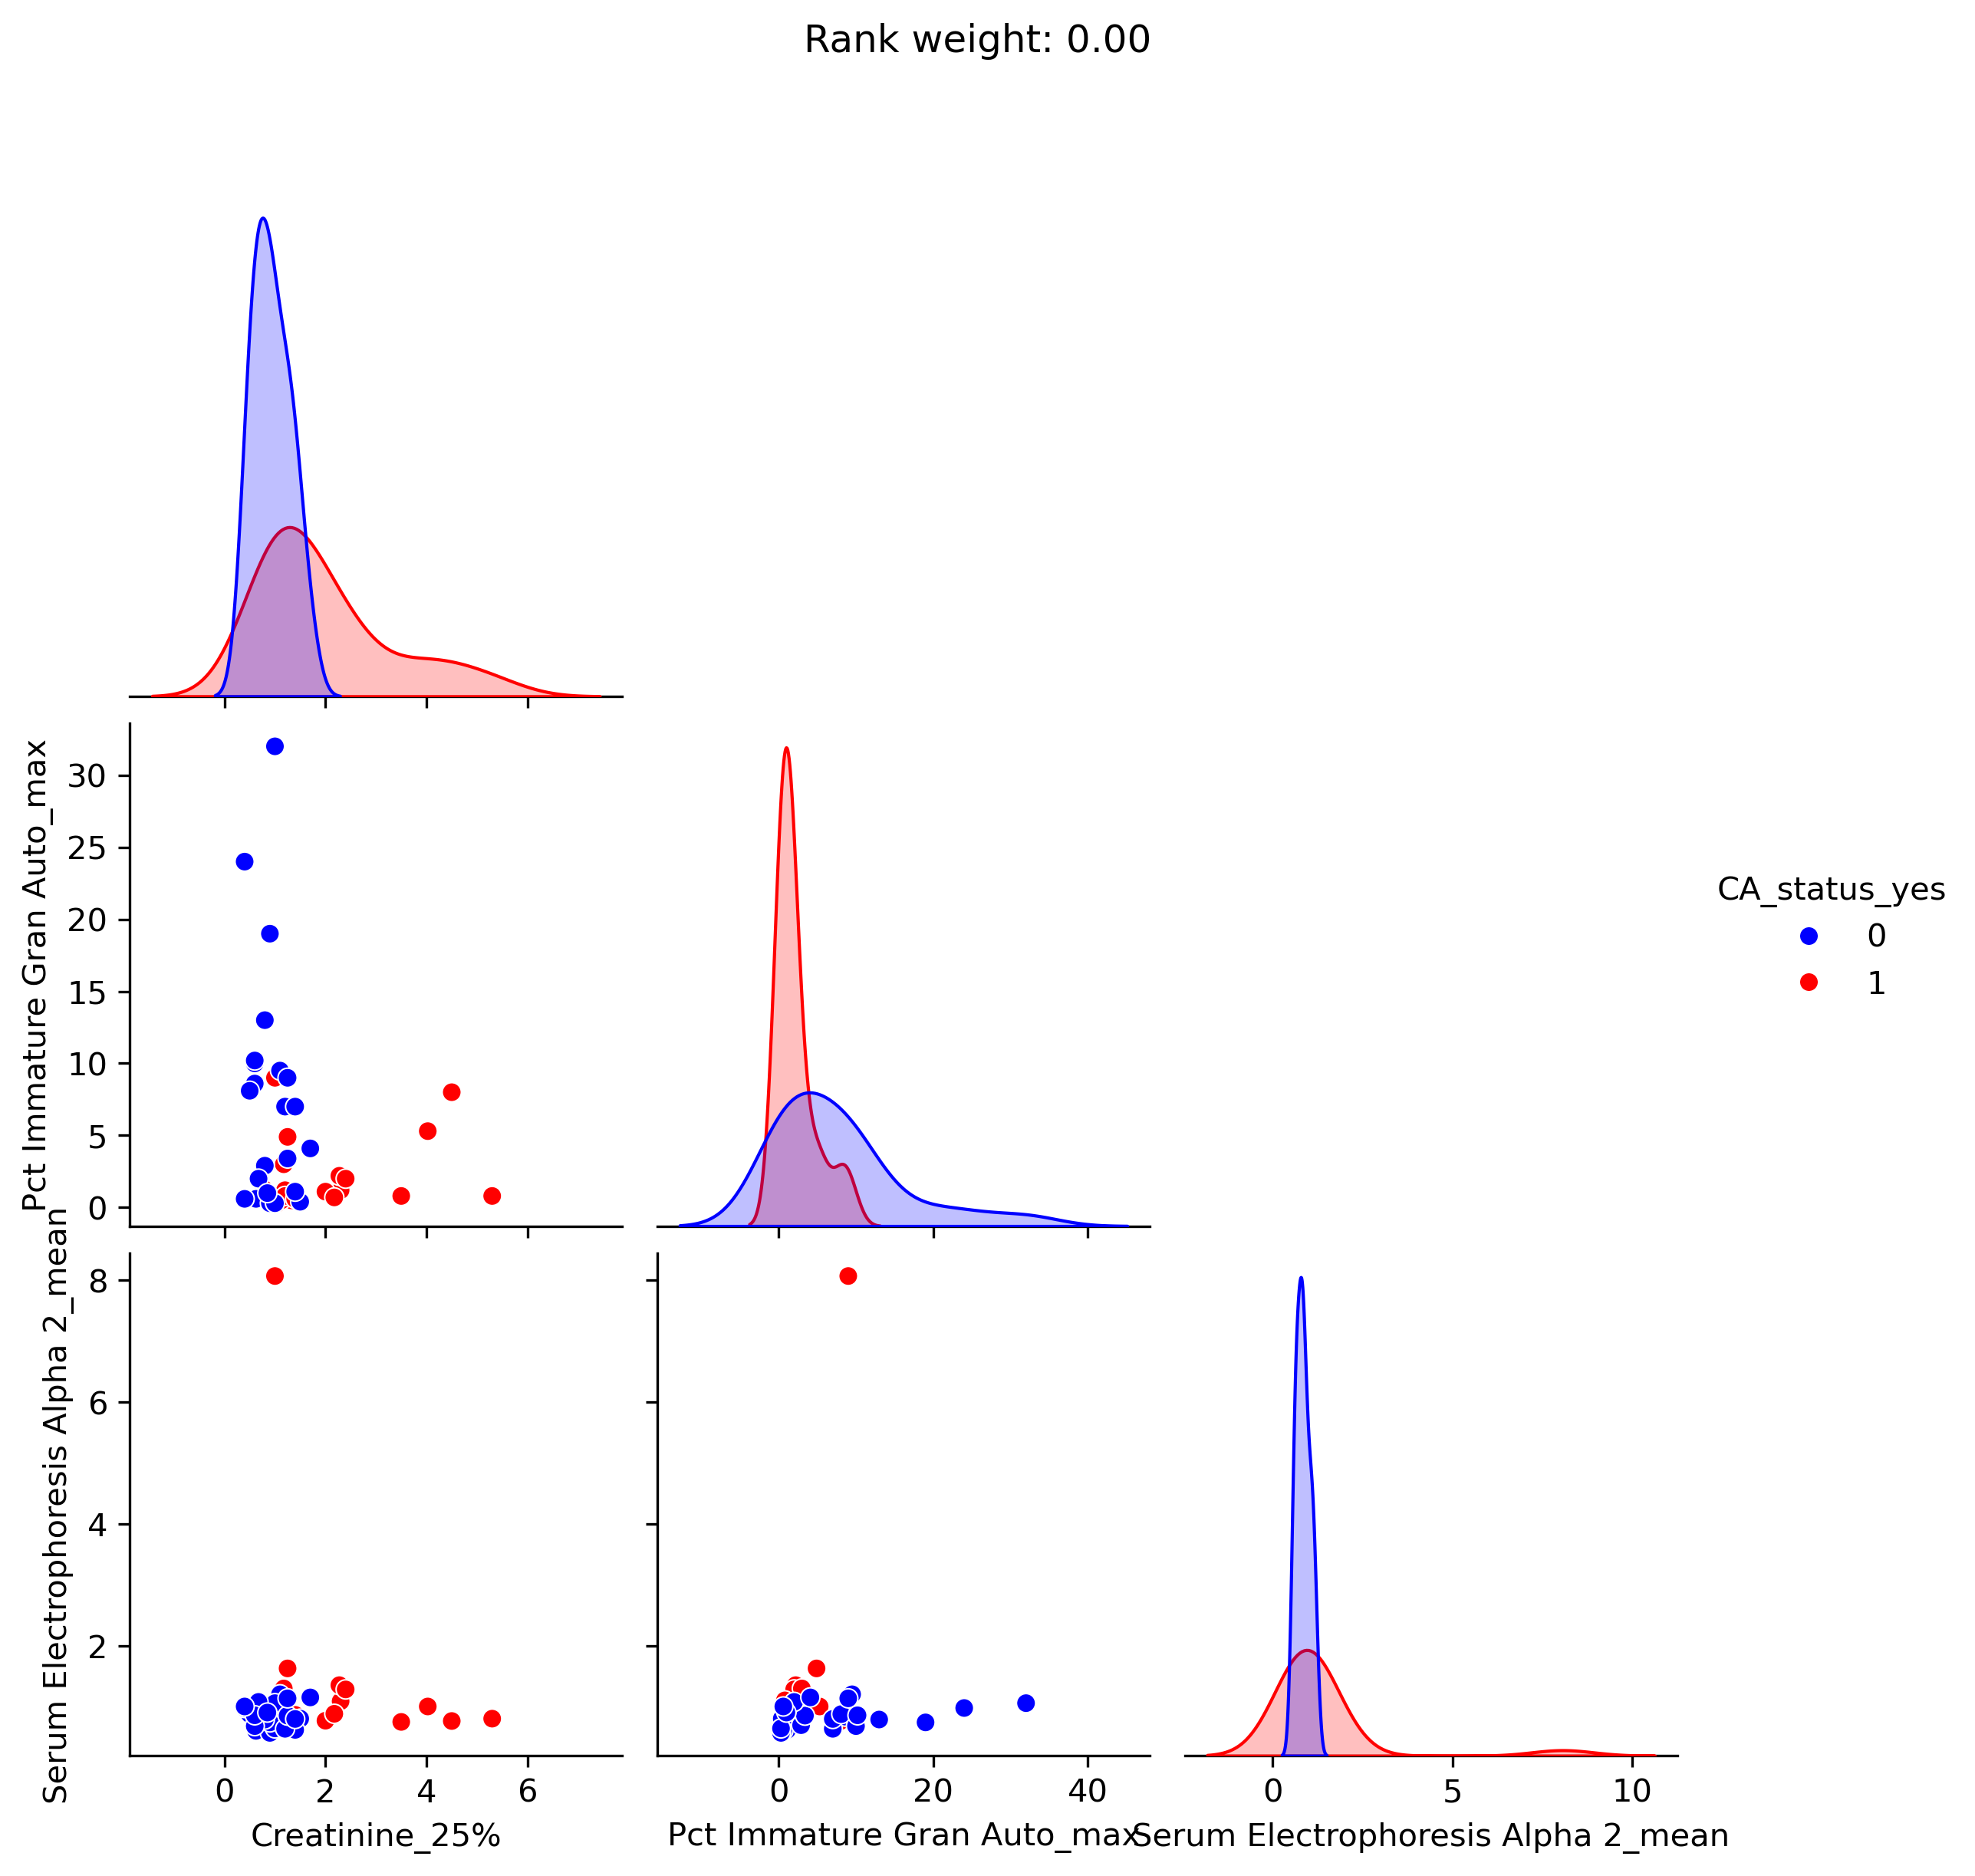

In [445]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

In [446]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [447]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



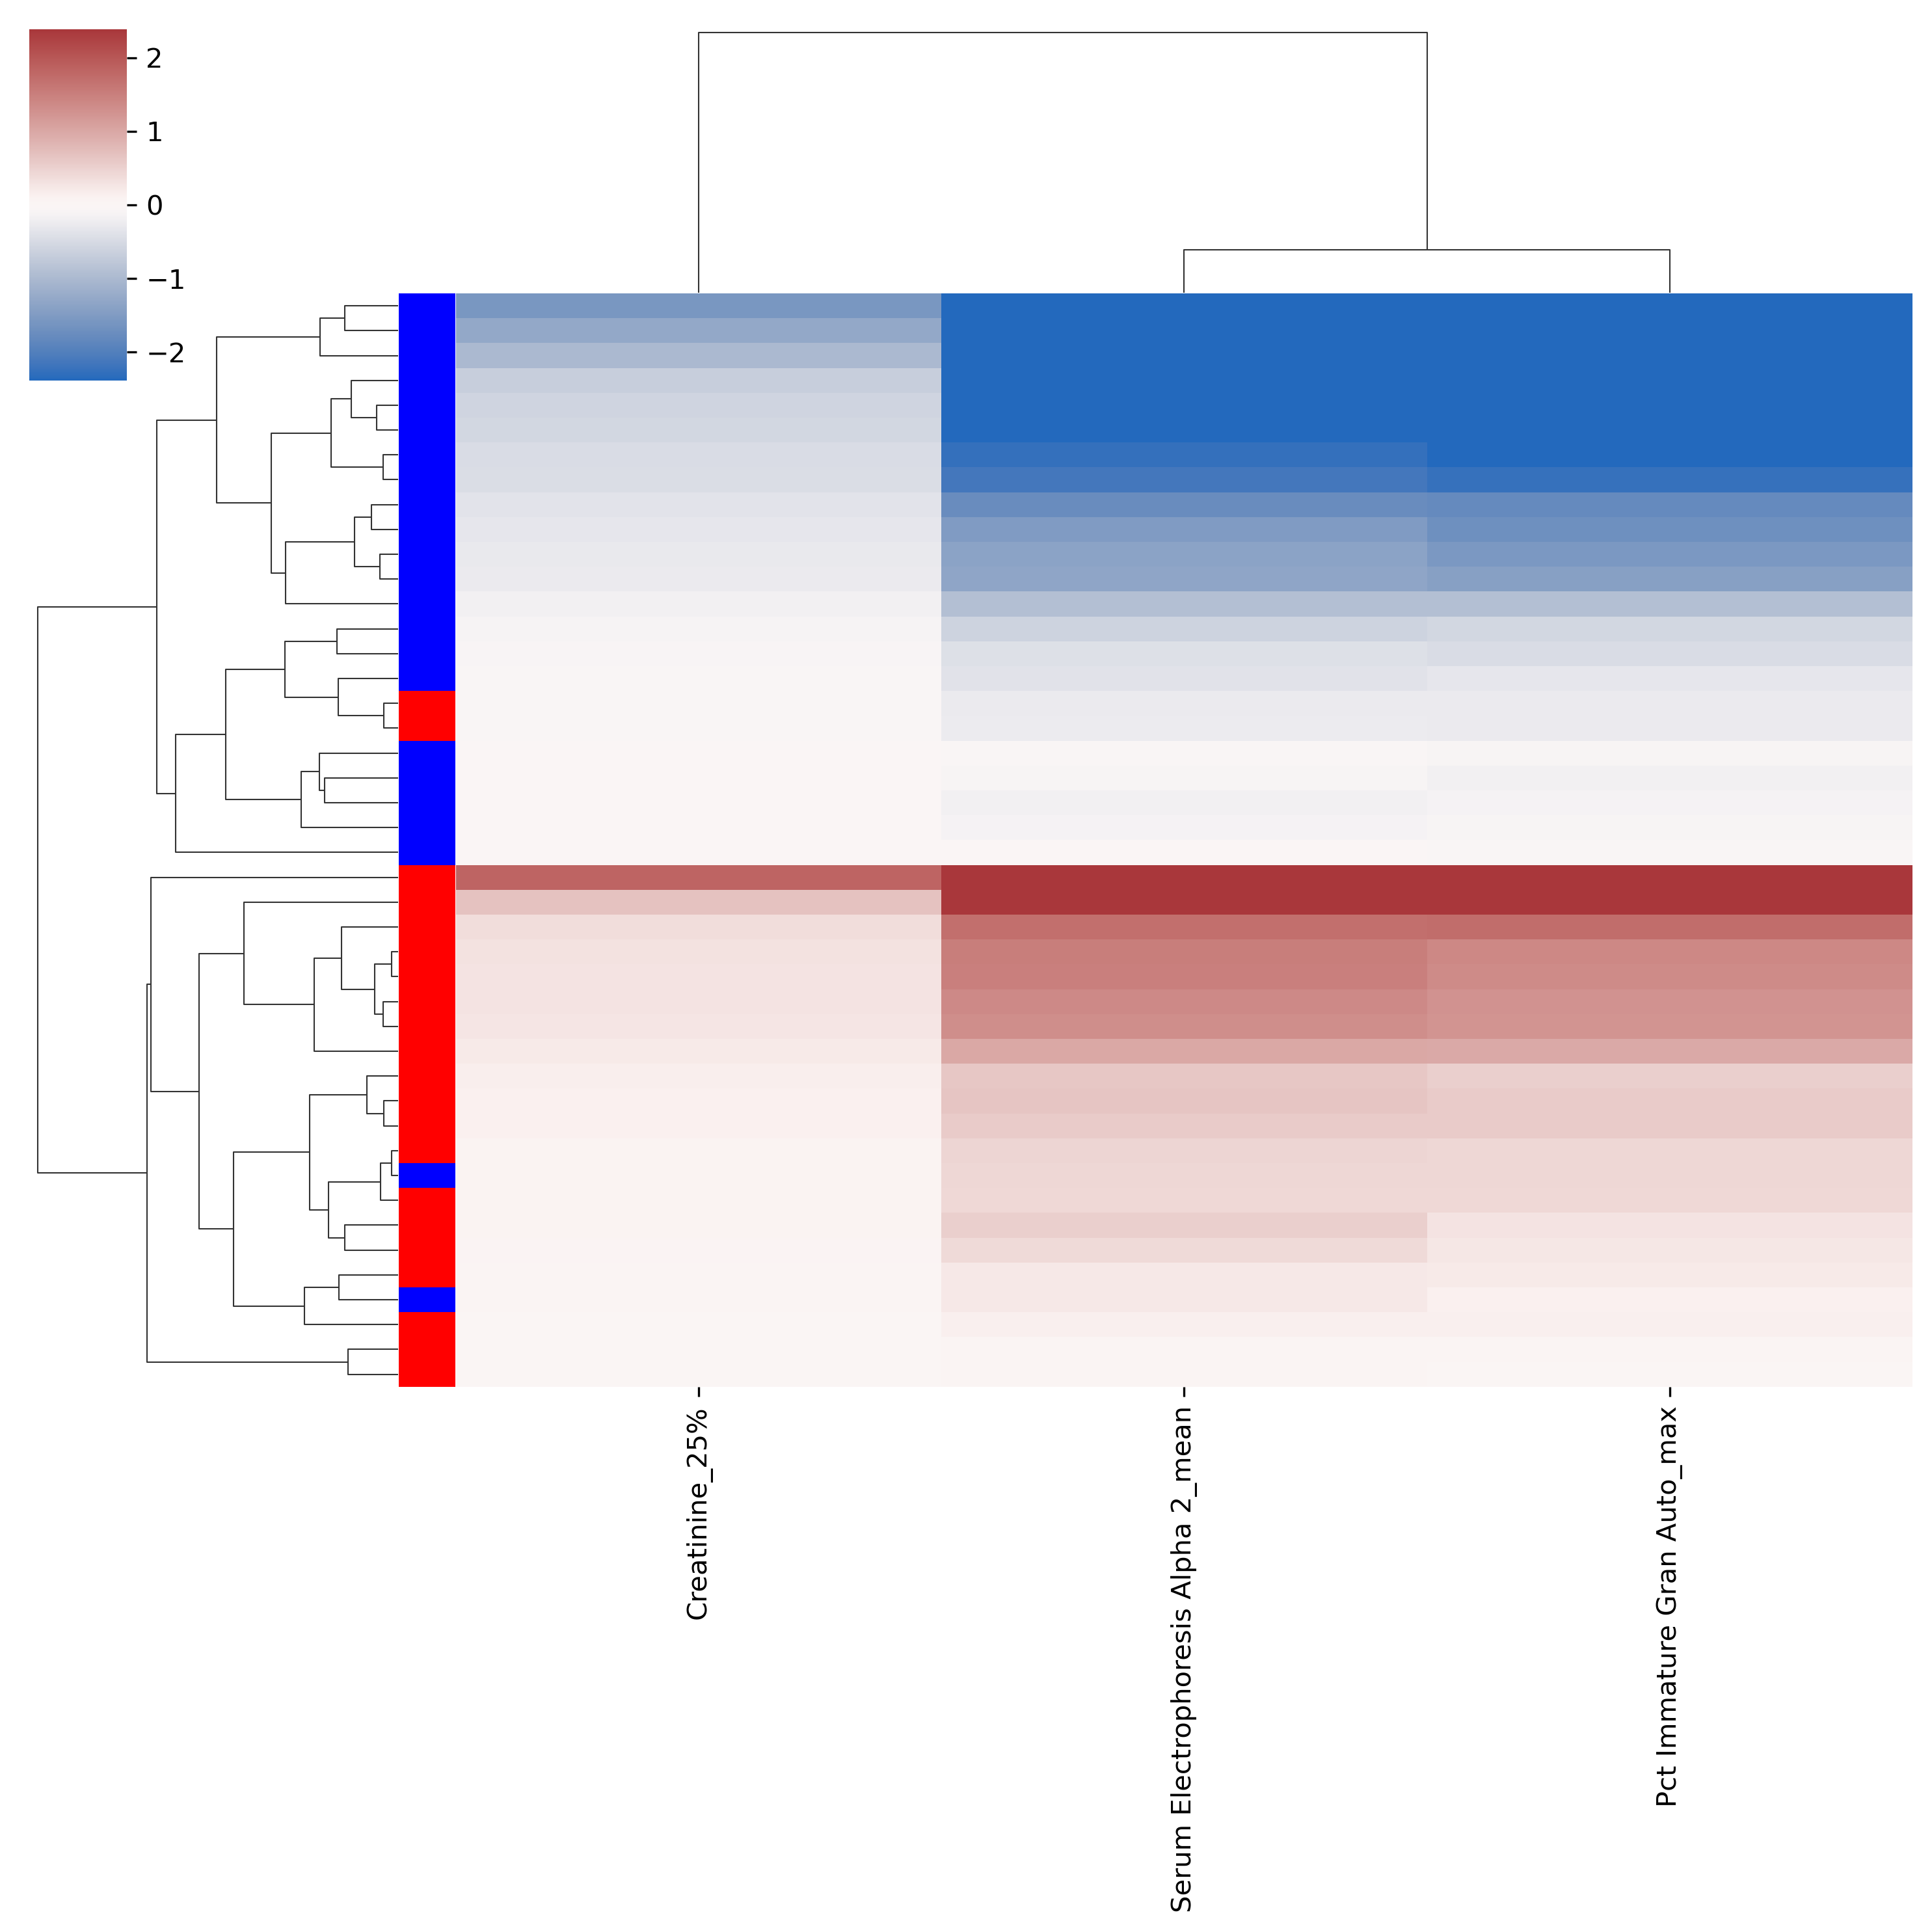

In [448]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [449]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = 7
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [450]:
nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=2000,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [451]:
feat_1 = IGtable.columns[feature_order[1]]
feat_2 = IGtable.columns[feature_order[2]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [452]:
# feat_1 = IGtable.columns[feature_order[5]]
# feat_2 = IGtable.columns[feature_order[6]]

# fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
# fig.update_traces(marker=dict(size=12))

# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=800,
#     height=800,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = feat_1,
#     yaxis_title = "Integrated Gradient for " + feat_1,
#     font=dict(size=20)
# )

# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
#     )
    
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )

# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text=feat_2,side = "right"),
#                     cmin = -1, cmax = 1)

# fig.show()

# sensitivity and specificity 

In [453]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  4
false positive:  1
false negative:  0
true positive:  4
true positive rate or recall/sensitivity:  1.0
positive predictive value or precision:  0.8
specificity or true negatie rate:  0.8
auc:  0.9500000000000001
f1 score:  0.888888888888889


# testing alt models on best feature list

In [454]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [455]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

ROC:  0.9
F1:  0.8888888888888888


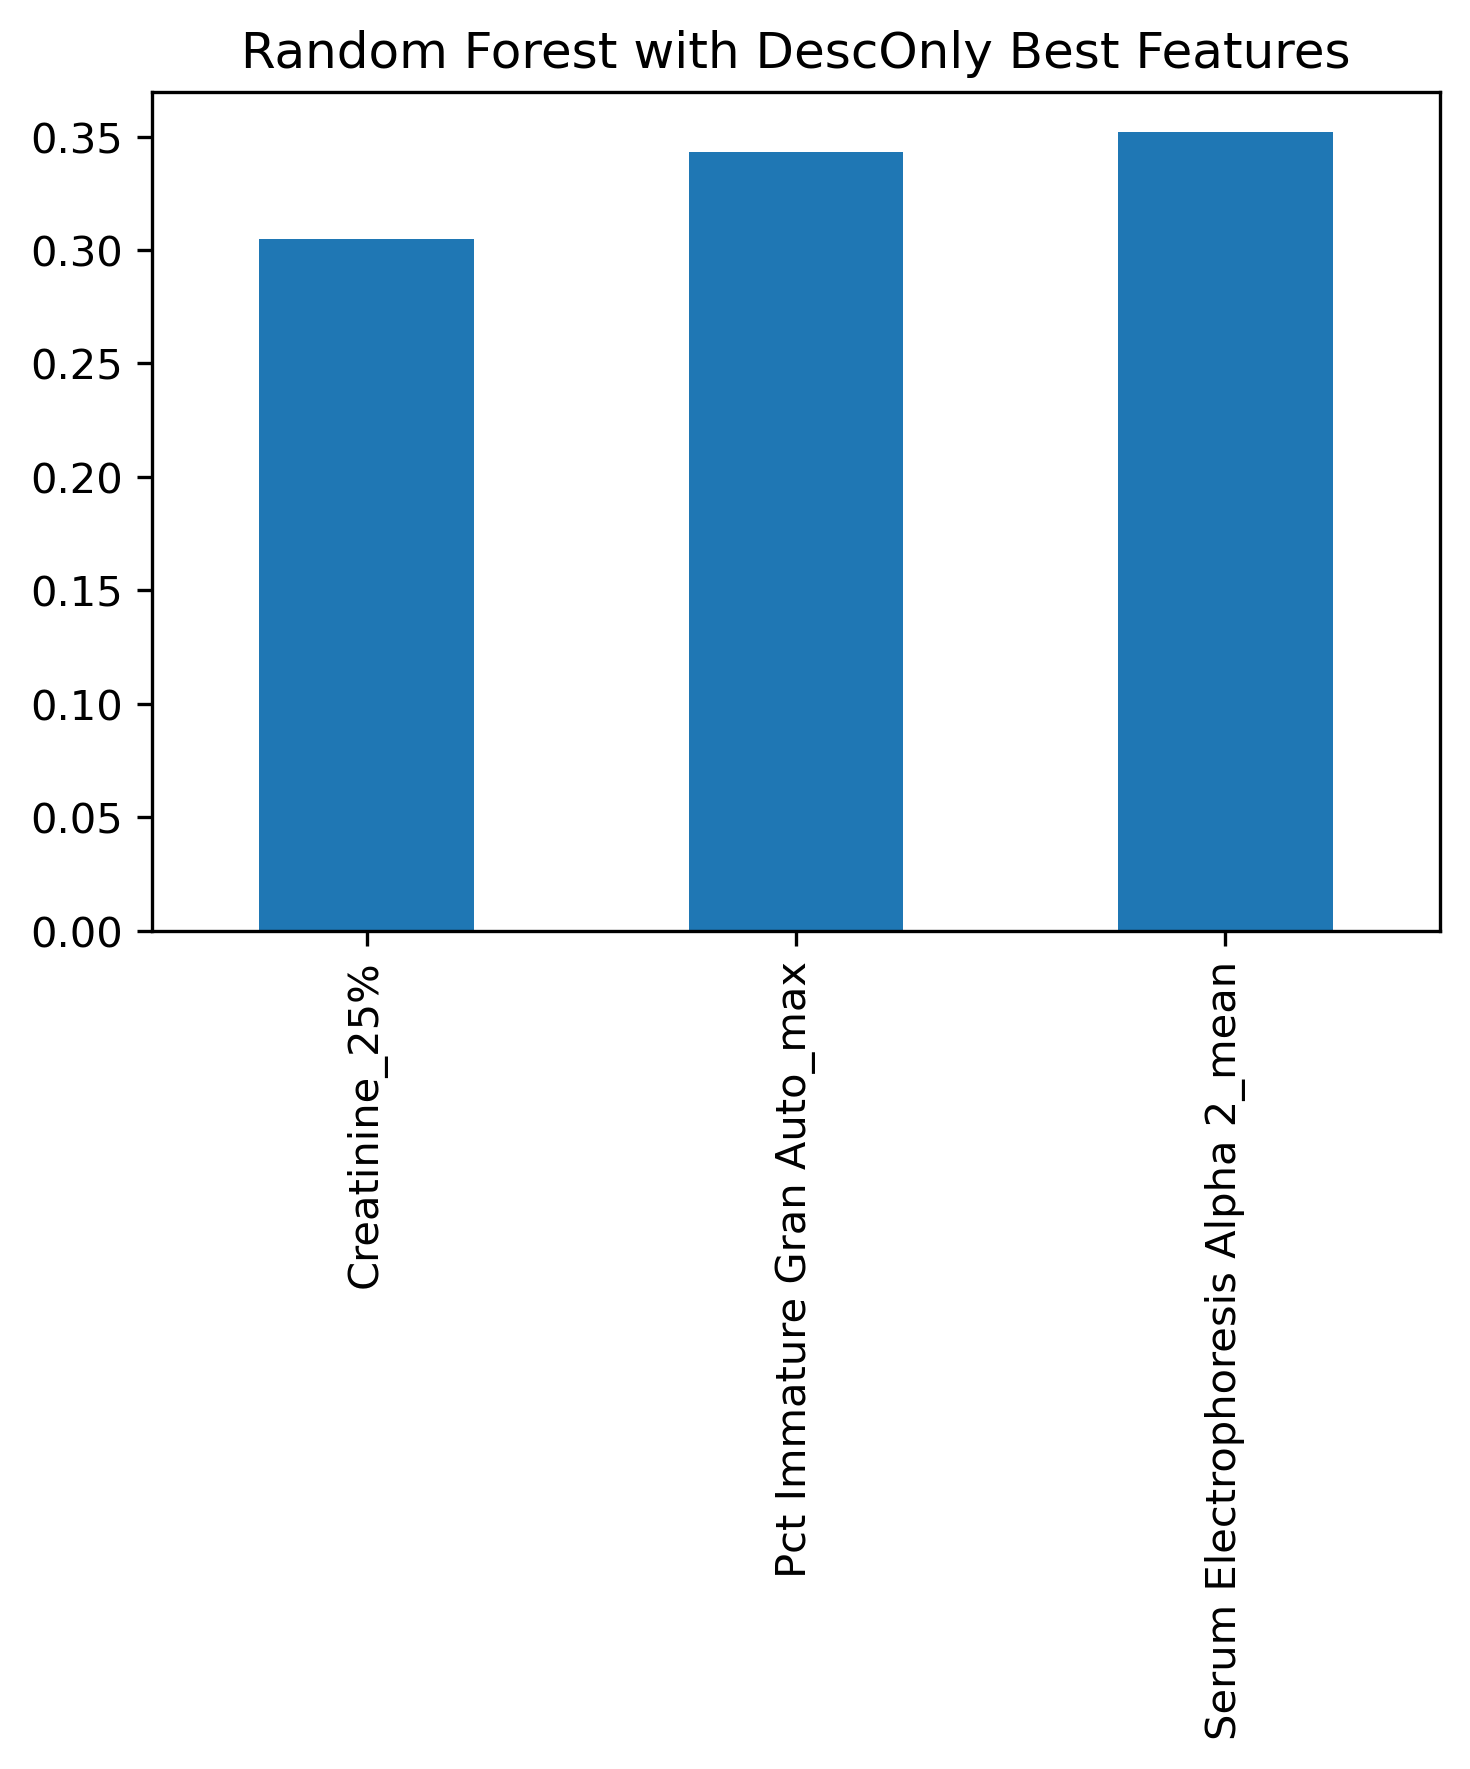

In [456]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with DescOnly Best Features")
fig.tight_layout()

ROC:  0.675
F1:  0.6666666666666666


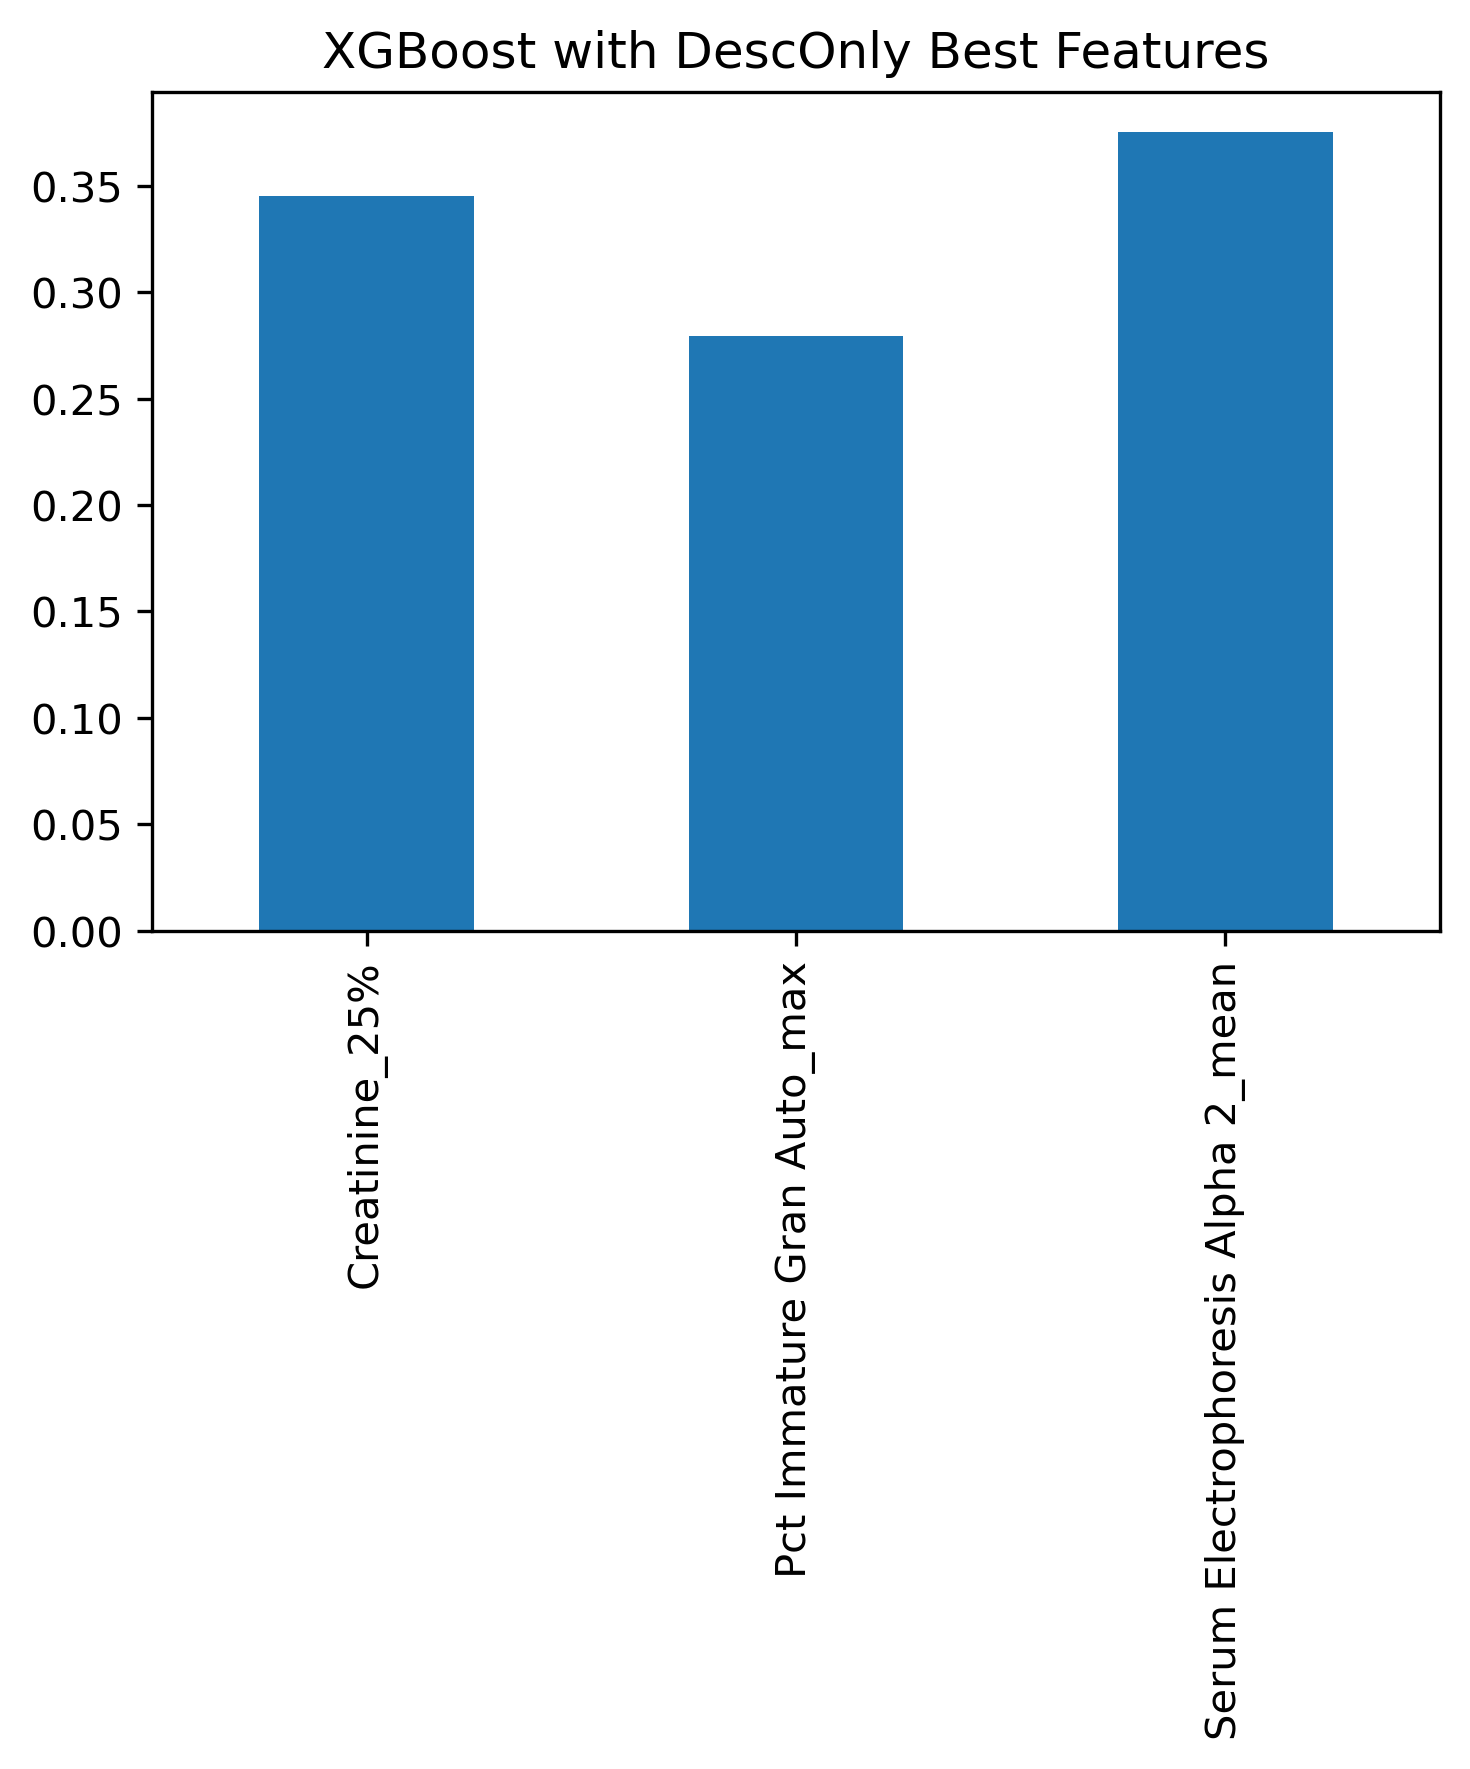

In [457]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with DescOnly Best Features")
fig.tight_layout()

In [458]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



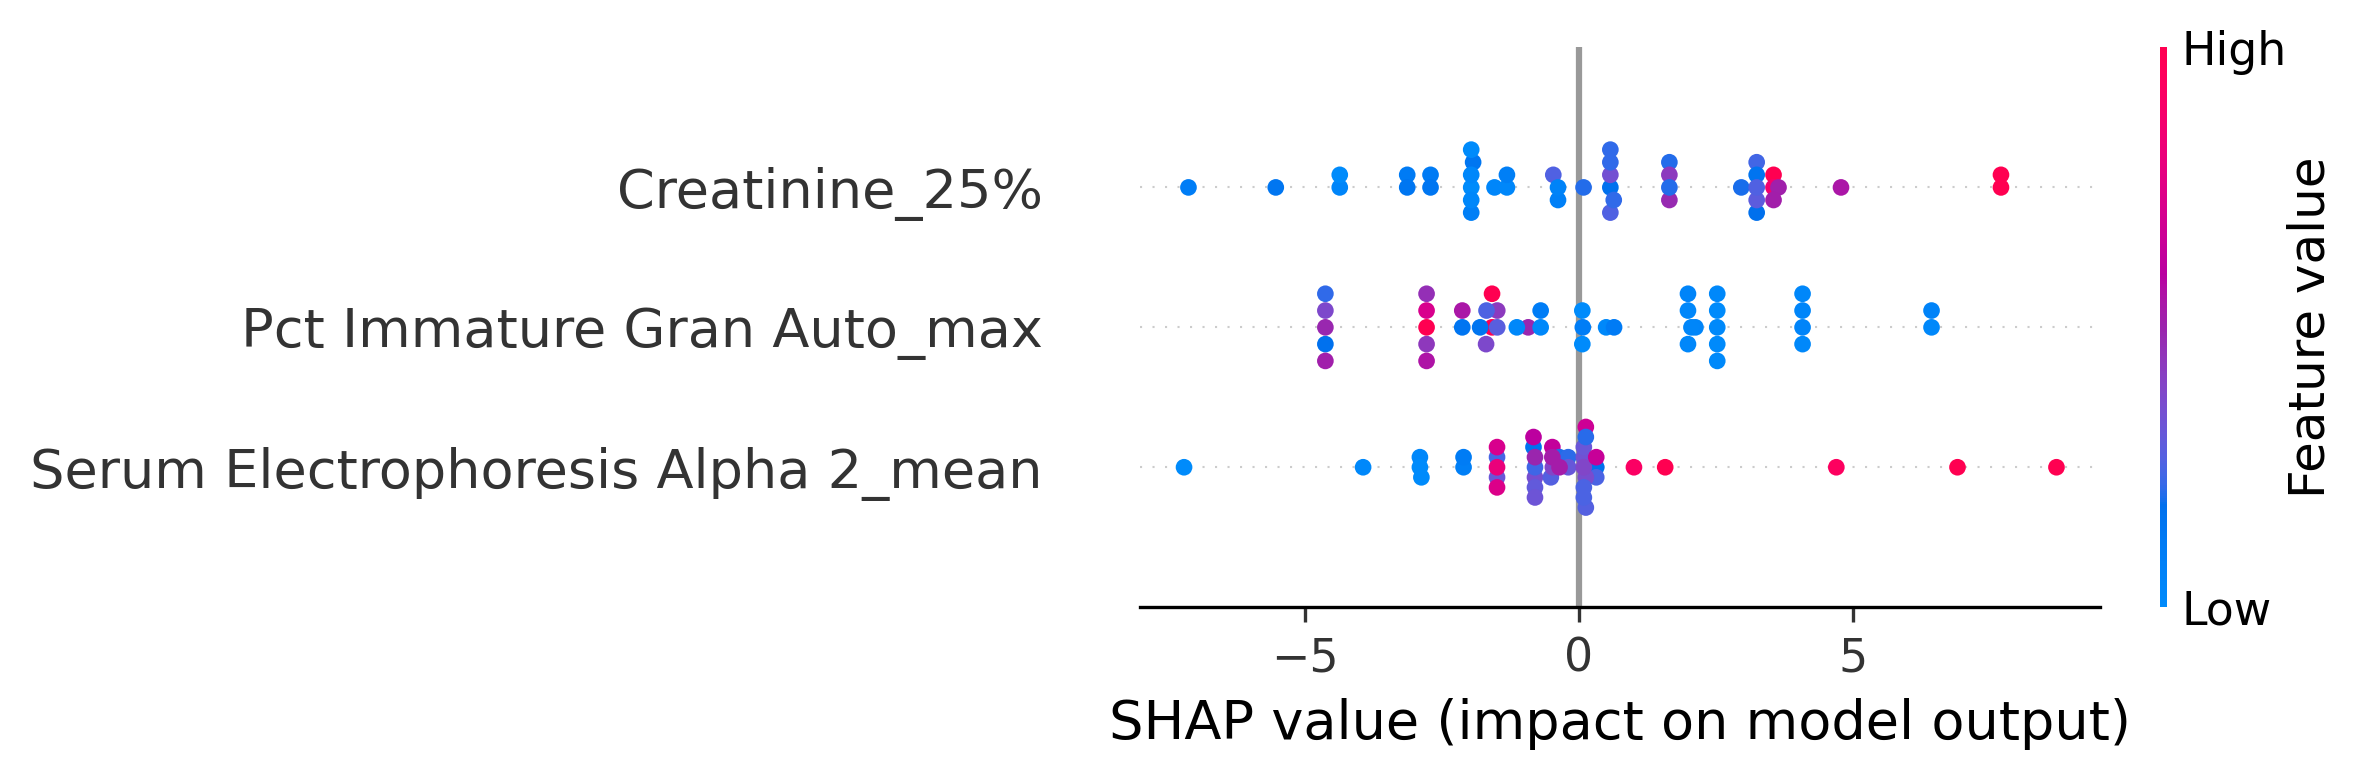

In [459]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# exporting selected features to dataframe

In [460]:
selected_features = list(X.columns[svm_set_ranks[selected_run].features]) #getting list of selected features
dataTablePositive = dataTable[dataTable[y_column_Classification] == 1] #filtering for positive patients
dataTablePositive.index = dataTablePositive['DeID'] #setting index to patient id
dataTableNegative = dataTable[dataTable[y_column_Classification] == 0] #filtering for negative patients
dataTableNegative.index = dataTableNegative['DeID'] #setting index to patient id
df_selectedfeatures_allpts = dataTable[selected_features]
df_selectedfeatures_allpts.index = dataTable['DeID'] #adding the patient identifiers back to the dataframe


#saving this output to a sheet
outputToExcel(df_data = df_selectedfeatures_allpts[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = dataTablePositive[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "positive")
outputToExcel(df_data = dataTableNegative[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "negative")


# correlation and heat maps for the best performing features of the SVM model

In [461]:
import seaborn as sns

In [462]:
dataTable

DeID  CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  \
0   B-02              1           0        1      0   48      9.466667   
1   C-03              1           1        0      1   59     17.000000   
2   E-01              1           0        1      0   50     71.300000   
3   E-02              1           0        1      0   64     20.466667   
4   F-03              1           0        0      1   61     52.000000   
5   G-02              1           1        0      1   36     30.000000   
6   I-01              1           1        0      1   55     33.000000   
7   I-03              1           0        1      0   67     10.033333   
8   J-02              1           1        0      1   68     26.000000   
9   K-02              1           1        0      1   68     27.000000   
10  M-02              1           0        1      0   70     24.800000   
11  N-03              1           0        0      1   69      8.000000   
12  O-03              1           1        0      1   71      4.233333   
13  Q-02              1           0        1      0   69     41.100000   
14  Q-03              1           1        0      1   41      3.466667   
15  T-01              1           0        0      0   71     14.433333   
16  V-02              1           0        0      1   79     50.000000   
17  W-01              1           0        0      1   57     42.000000   
18  X-01              1           0        1      0   80      5.300000   
19  X-02              1           0        1      0   63     38.233333   
20  Y-02              1           1        1      0   57     12.766667   
21  A-02              0           1        1      0   74      7.266667   
22  B-03              0           0        0      1   43     18.000000   
23  C-01              0           1        0      0   56     27.000000   
24  C-02              0           0        0      1   59     33.000000   
25  E-03              0           0        1      0   62     13.866667   
26  F-01              0           0        0      1   55    147.000000   
27  G-03              0           1        1      0   69     11.533333   
28  H-01              0           0        1      0   56     47.066667   
29  H-02              0           0        0      1   65     26.000000   
30  M-01              0           0        0      1   47     83.000000   
31  N-01              0           0        0      0   79     15.000000   
32  N-02              0           0        0      1   76     10.000000   
33  P-01              0           0        0      1   77     53.000000   
34  P-02              0           1        0      1   64     26.000000   
35  Q-01              0           1        1      0   57     48.800000   
36  R-01              0           0        0      1   68     21.000000   
37  R-03              0           1        1      0   62     12.966667   
38  S-02              0           1        0      1   69     20.000000   
39  T-02              0           0        0      1   60     19.000000   
40  V-01              0           1        0      1   66     43.000000   
41  W-02              0           0        1      0   72     13.500000   
42  Y-01              0           0        0      1   59     40.000000   
43  Z-01              0           1        0      0   72      2.000000   

    ChemoTx  HematologicTx  RadiationTx  ...  NT Pro BNP_50%  NT Pro BNP_75%  \
0         0              0            0  ...          3660.5         5185.25   
1         2              0            0  ...          3321.0         4270.00   
2         0              0            0  ...          1260.0         1548.00   
3         0              0            0  ...         16284.0        28544.00   
4         4              1            0  ...           130.0          148.00   
5         0              0            0  ...          5527.0         6661.00   
6         4              0            0  ...           546.0         1397.50   
7         0              0       

In [463]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [464]:
outputToExcel(df_data = feature_correlation, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = feature_correlation_CApositive, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCApos")
outputToExcel(df_data = feature_correlation_CAnegative, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCAneg")

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



In [465]:
colormap = "RdBu"

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



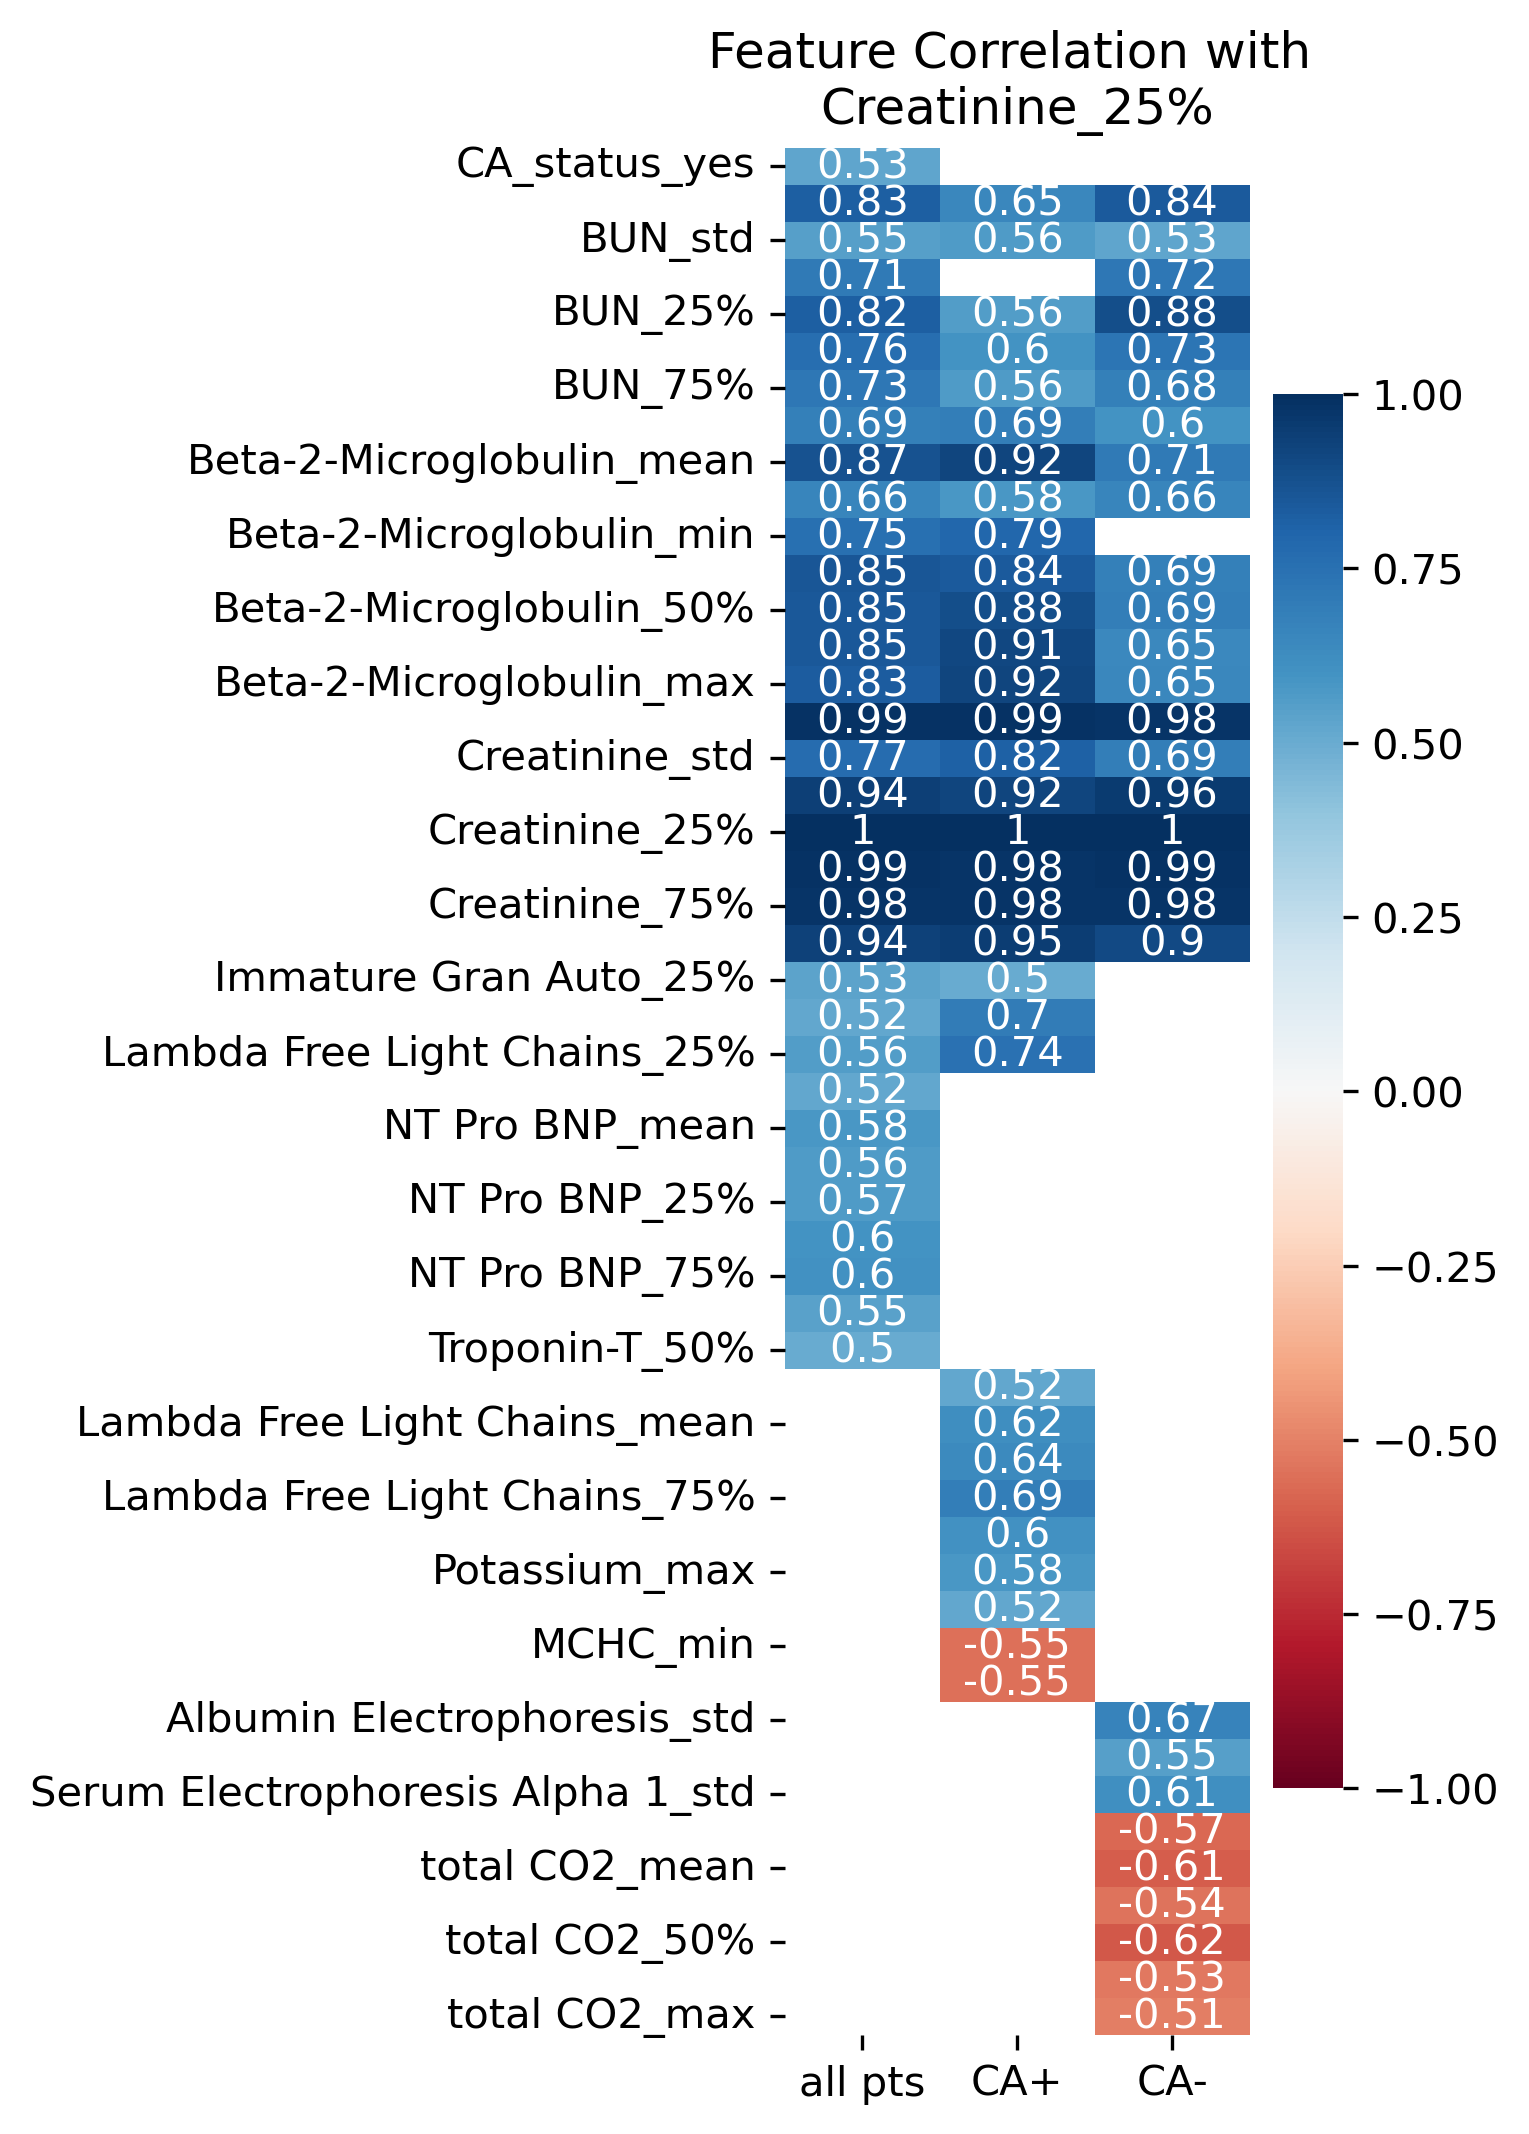

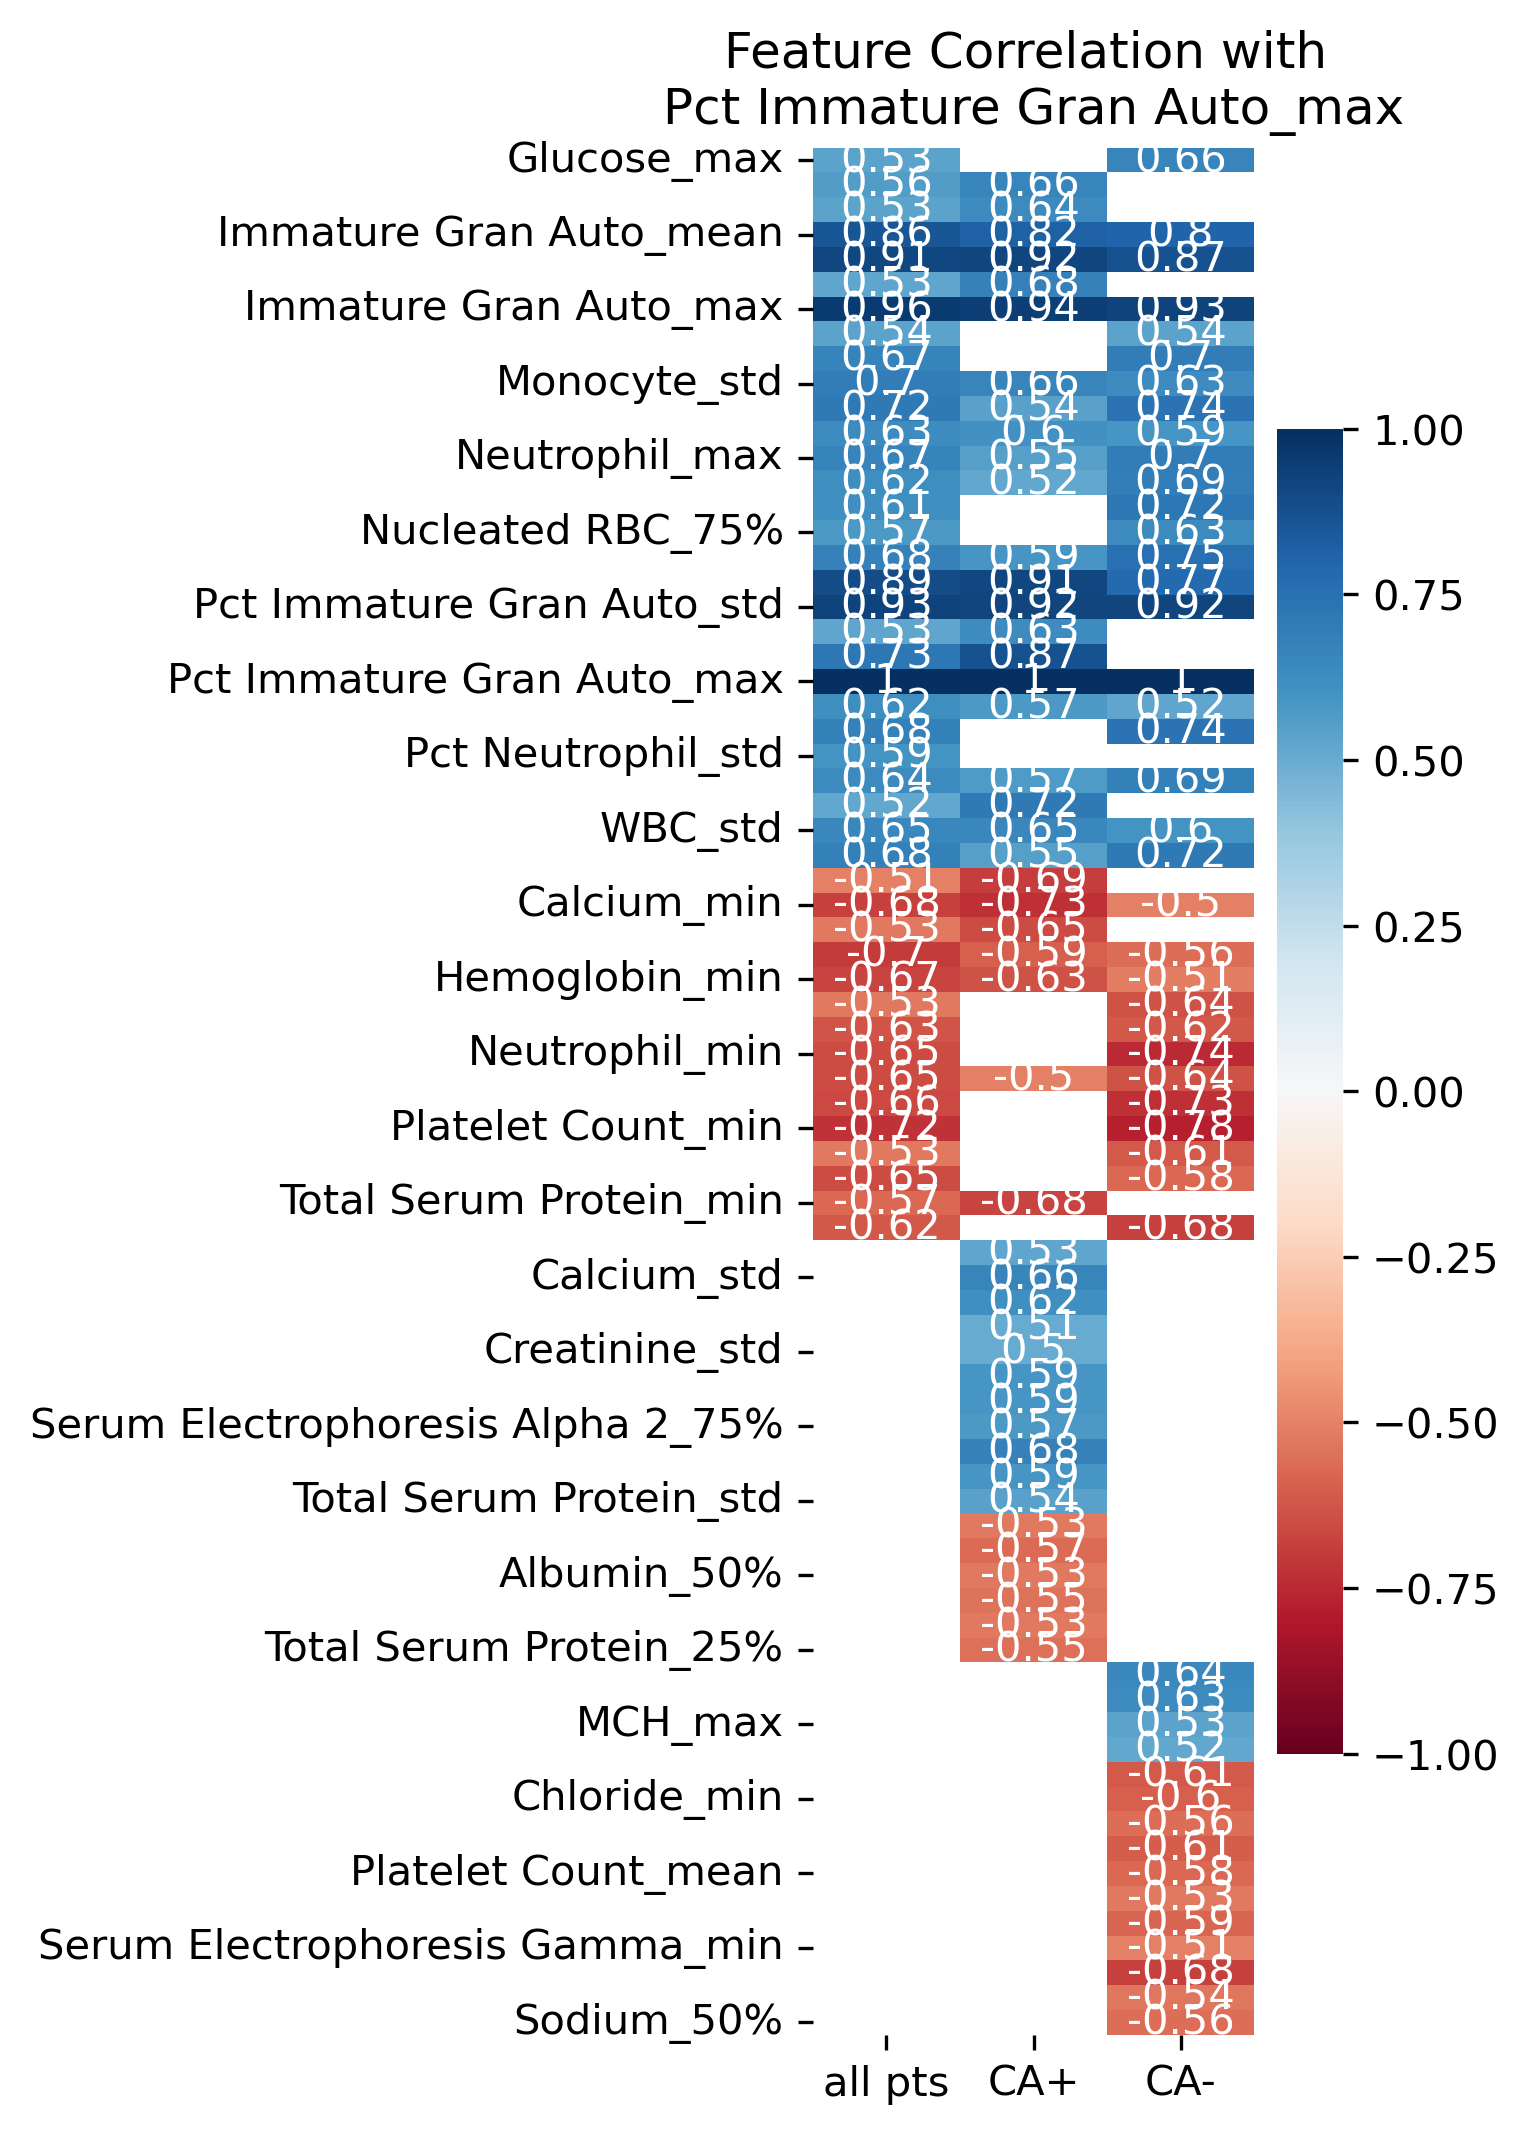

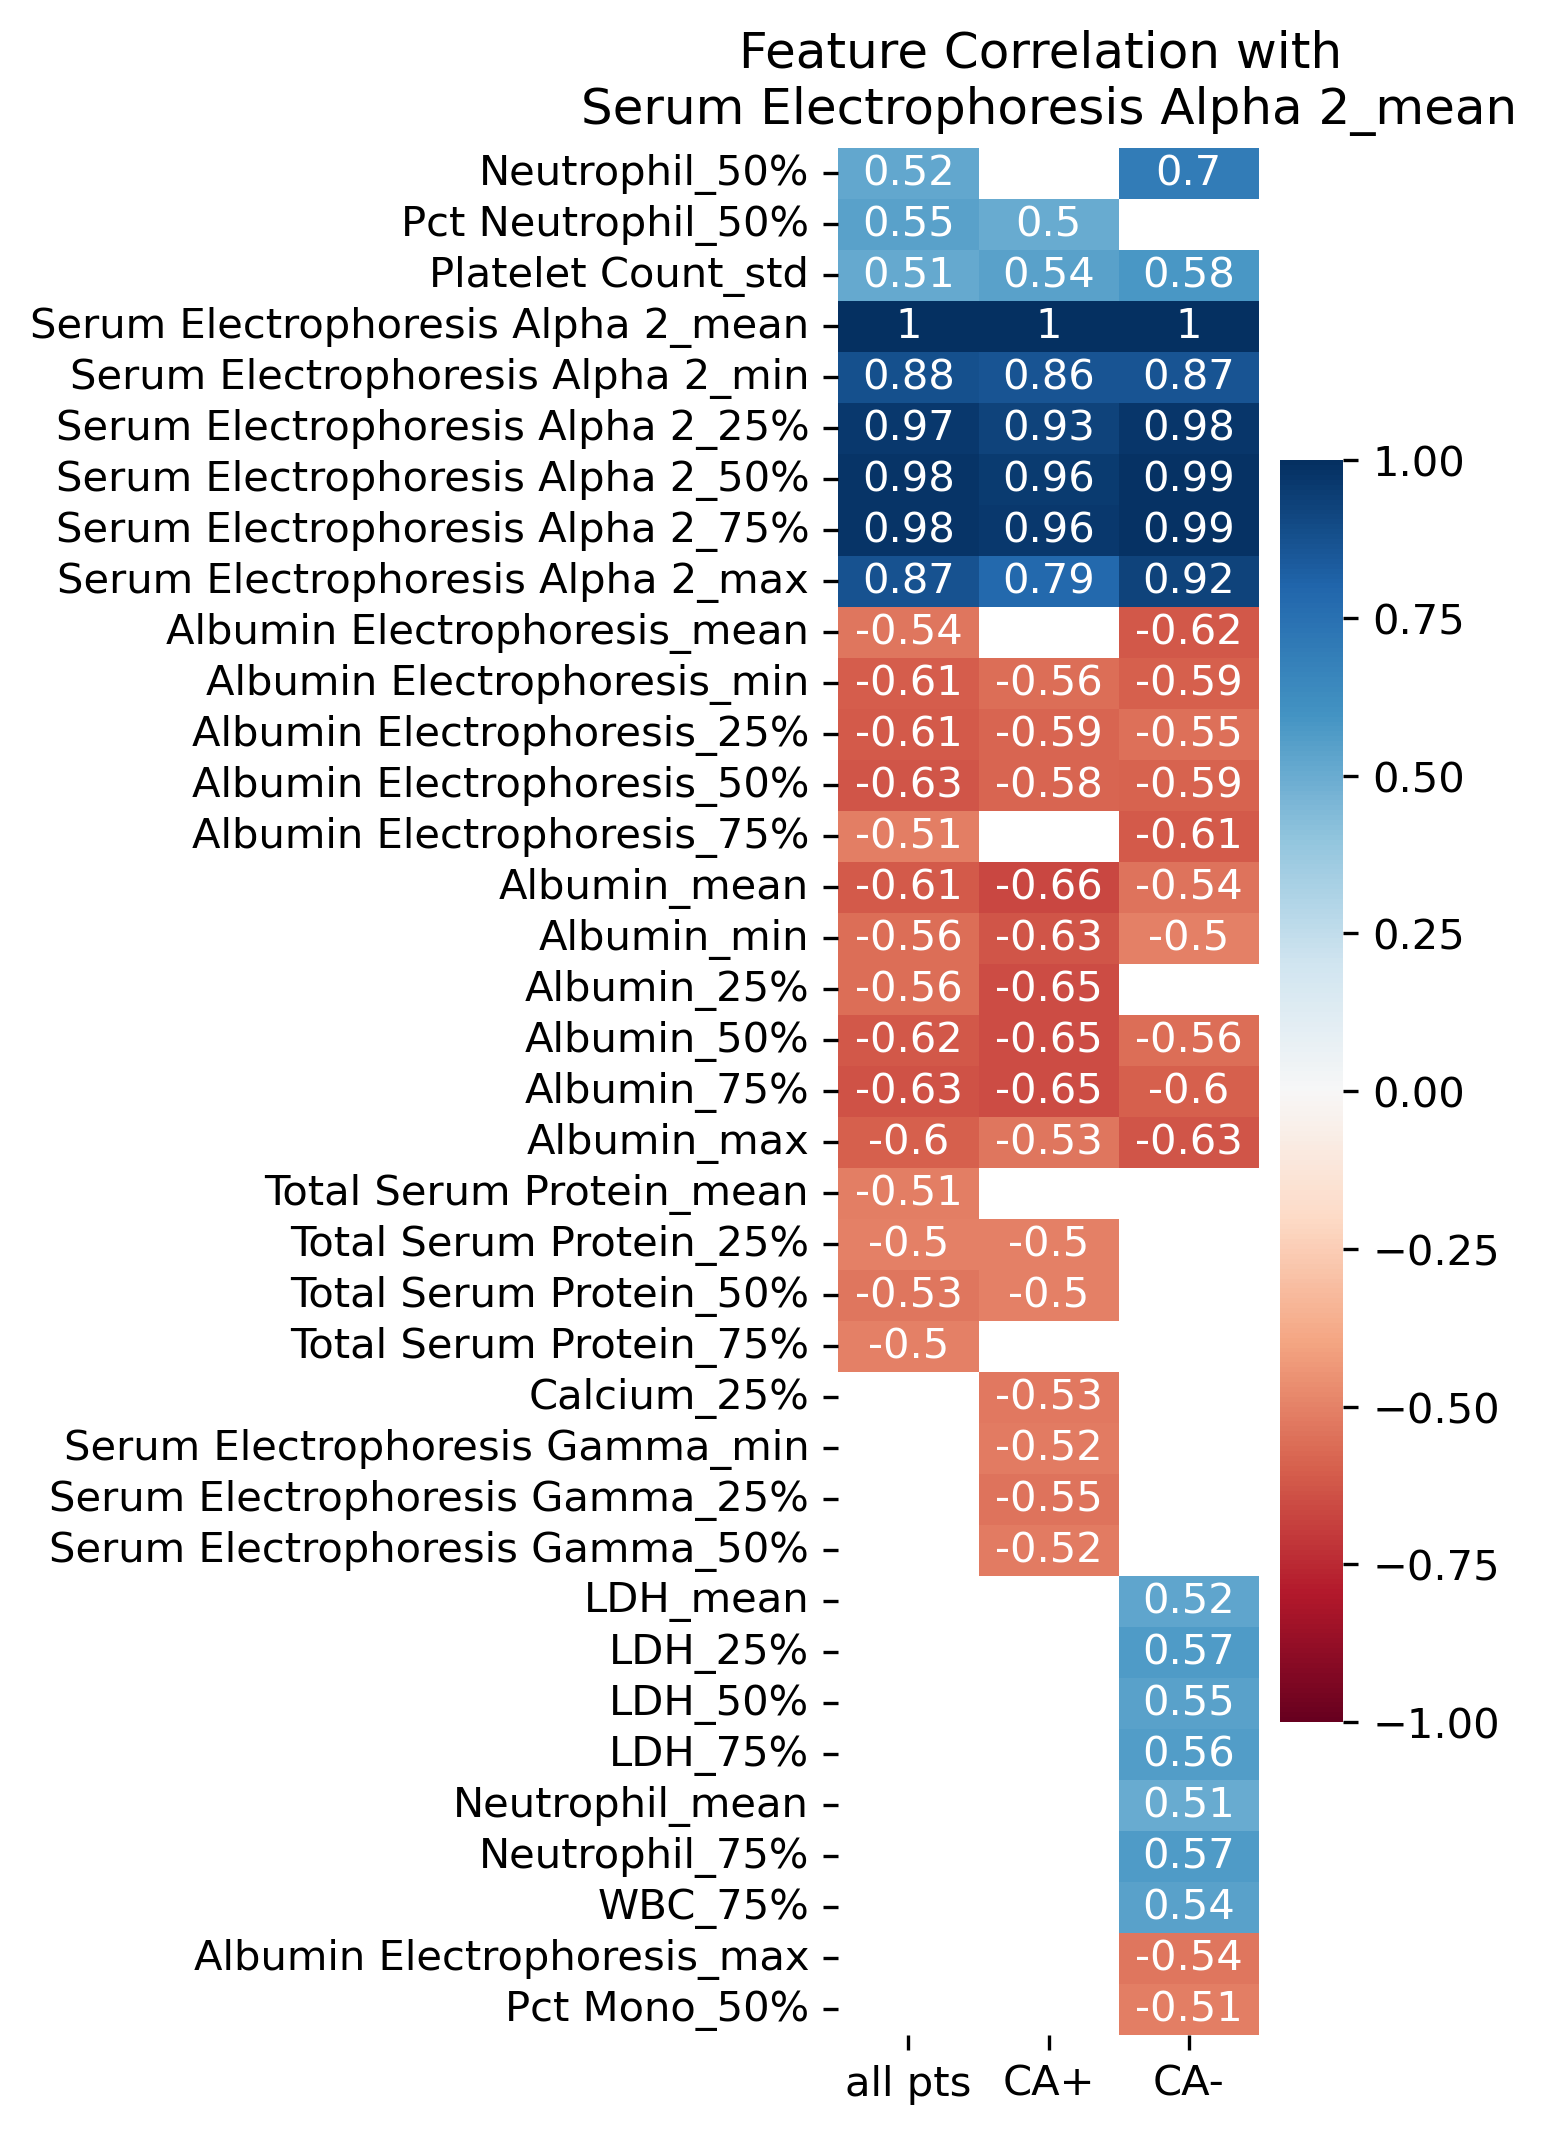

In [466]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix ,
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name.replace("%", "").replace("/",""))

    fig, ax = plt.subplots(figsize = (5,7),layout = 'constrained')
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, vmin= -1, vmax = 1, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon =feature_name.replace("%", "").replace("/","") + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')